In [951]:
import os
import numpy as np
from scipy.stats import mode
from astropy.time import Time
from astropy import units as u
import matplotlib.pyplot as plt
from astropy import constants as c
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from astropy.io import fits
from astropy.coordinates import SkyCoord, EarthLocation

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 18

path1 = '/Users/arcticfox/Documents/atmospheres/v1298tau'
path = '/Users/arcticfox/Documents/GitHub/v1298_atms'

In [2]:
TIMES = np.load('mjddates.npy', allow_pickle=True)
WAVELENGTHS = np.load('interpolized_wave_fresh_bc_corr.npy', allow_pickle=True)
SPECTRA = np.load('interpolized_spec_fresh.npy', allow_pickle=True)
ORDERS = np.load('interpolized_order_fresh.npy', allow_pickle=True)
AIRMASS = np.load('airmass.npy', allow_pickle=True)

In [5]:
TIMES = Time(TIMES, format='mjd').jd

In [6]:
from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, len(WAVELENGTHS))
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

In [8]:
BOTH = np.where(TIMES<=2458870.762)[0]
TRANSIT_C = np.where( (TIMES>2458870.762) & (TIMES<=2458870.941))[0]
OUT = np.where( TIMES>2458870.941)[0]

In [10]:
def doppler(wave, center):
    delta = center - wave
    shift = (delta/center) * c.c
    return shift.to(u.km/u.s)

In [11]:
WAVELENGTHS[10][np.where( (WAVELENGTHS[10] > 655) & (WAVELENGTHS[10]<=656) )[0]]

array([655.00045031, 655.0009514 , 655.00145249, ..., 655.99878304,
       655.99928328, 655.99978352])

In [12]:
def find_order(wavelength, order, region):
    inds = np.where( (wavelength >= region[0]) &
                     (wavelength <= region[-1]))
    return np.unique(order[inds])

###############################################################
###############################################################

def identify_where(wavelength, orders, order_number, region):
    all_inds = np.array([])
    
    for on in order_number:
        inds = np.where( (wavelength >= region[0]) &
                         (wavelength <= region[-1]) &
                         (orders==on))
        all_inds = np.append(all_inds, inds)
    
    if len(inds) > 0:
        return inds
    else:
        print("Not an observed wavelength")
        return
    
###############################################################
###############################################################

def fit_minimum(wavelength, spectra, inds):
    for i in range(len(wavelength)):
        plt.plot(wavelength[i][inds], spectra[i][inds], 'k')
        
    median = np.nanmedian(spectra, axis=0)[inds]
    plt.plot(wavelength[10][inds], median, 'r')
    
    x = np.arange(wavelength[10][inds][0], wavelength[10][inds][-1], 0.001)
    fit = np.polyfit(wavelength[10][inds], median, deg=2)
    model = np.poly1d(fit)
    
    model_fit = model(x)
    plt.plot(x, model_fit, 'y')
    minimum = np.argmin(model_fit)
    plt.plot(x[minimum], model_fit[minimum], 'y*', ms=20)
    plt.title(x[minimum])
    return x[minimum]

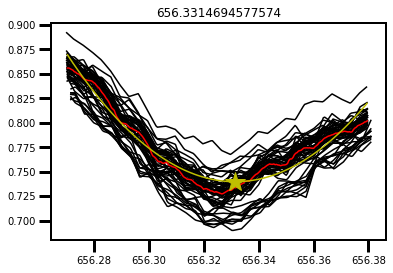

In [15]:
halpha_order = find_order(WAVELENGTHS[10], ORDERS[10], [656.27,656.38])

halpha_inds = identify_where(WAVELENGTHS[10], ORDERS[10], halpha_order, 
                             [656.27, 656.38])
halpha_position = fit_minimum(WAVELENGTHS, SPECTRA, halpha_inds)
halpha_true = 656.3

# Checking orders

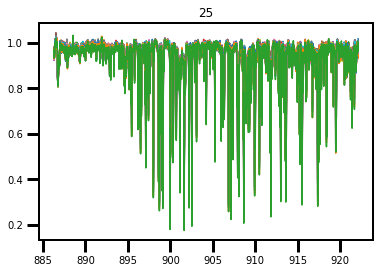

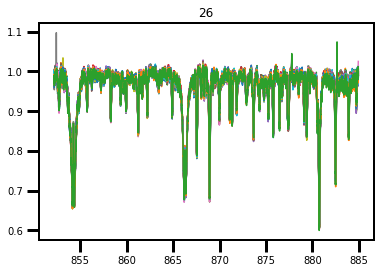

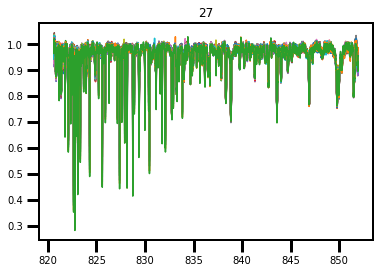

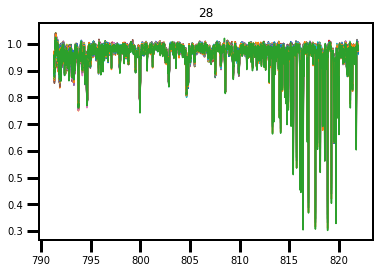

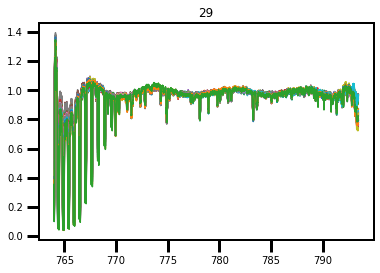

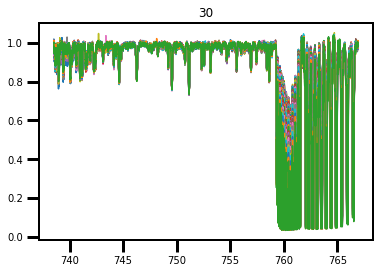

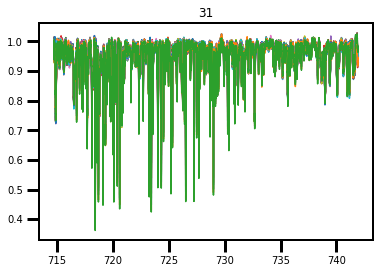

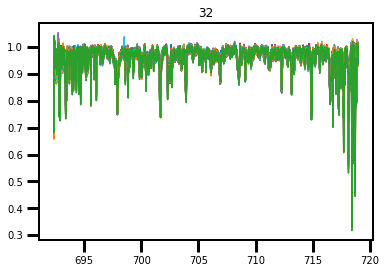

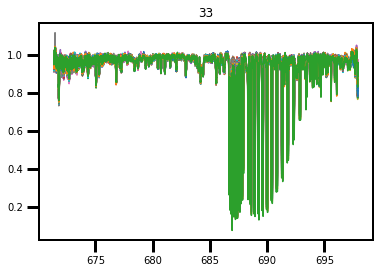

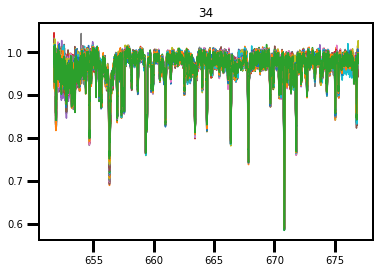

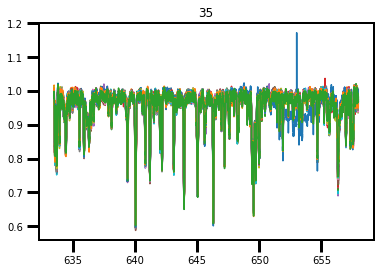

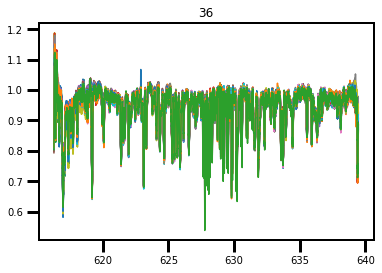

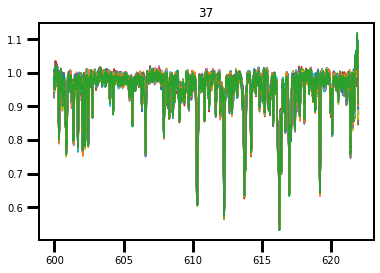

In [16]:
%matplotlib inline
for o in np.arange(25, 38, 1, dtype=int):
    
    for i in range(len(WAVELENGTHS)):
        q = ORDERS[i] == o
        plt.plot(WAVELENGTHS[i][q], SPECTRA[i][q])
        plt.title(o)
    plt.show()

# Using tellurics to remove RV signals

In [17]:
import h5py
f = h5py.File(os.path.join(path1, 'telluric_model_r.hdf'), 'r')

[]


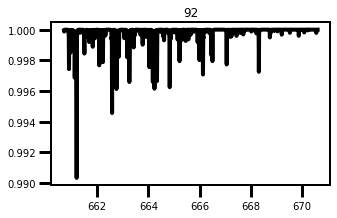

In [18]:
%matplotlib inline


plt.rcParams['figure.figsize'] = (5,3)
for key in f['wavelength_solution']['fiber_2'].keys():
    telluric_wave = f['wavelength_solution']['fiber_2'][key][()]
    telluric_spec = f['telluric_model']['fiber_2'][key][()]
    if key == '92':
        plt.figure(figsize=(5,3))
        plt.plot(telluric_wave-0.24, telluric_spec, 'k', linewidth=4)
        same = np.where((WAVELENGTHS[0] >= telluric_wave[0]) &
                        (WAVELENGTHS[0] <= telluric_wave[-1]) &#)[0]
                        (ORDERS[0] == 29))[0]
        plt.plot(WAVELENGTHS[0][same], SPECTRA[0][same], 'w', linewidth=1)
        plt.title(key)
        
print(np.unique(ORDERS[12][same])    )#
plt.show()


In [19]:
stellar_waves = [[676.759, 676.903],
                 [661.323, 661.484], [670.342, 670.466], [662.726, 662.878], [663.965, 664.102],
                 [647.536, 647.687], [654.589, 654.745], 
                 [748.144, 748.351], [749.849, 749.999], [744.262, 744.462], [748.140, 748.374],
                 [752.486, 752.657], [752.242, 752.438],
                 [775.099, 775.242], [780.751, 780.935], [777.177, 777.354], [771.003, 771.178]
                ]

stellar_orders = [33,
                  34, 34, 34, 34,
                  35, 35,
                  30, 30, 30, 30, 
                  30, 30, 
                  29, 29, 29, 29
                 ]

In [20]:
telluric_waves = [[830.341, 830.491], [832.871, 832.953], [831.528, 831.609], [824.275, 824.316],
                  [827.878, 827.939], [828.872, 828.927], #[828.112, 828.192], 
                  [789.532, 789.575], [770.208, 770.251],
                  [725.722, 725.774], [723.153, 723.204], [729.927, 729.967], [724.278, 724.359],
                  [717.314, 717.344], [717.201, 717.261], [718.545, 718.612], [716.147, 716.181],
                  [718.371, 718.433],
                  [694.686, 694.730], [692.895, 692.932], [692.261, 692.312], [691.825, 691.886]
                 ]
telluric_orders = [27, 27, 27, 27,
                   27, 27, #27,
                   29, 29, 
                   31, 31, 31, 31, 
                   32, 32, 32, 32,
                   32,
                   33, 33, 33, 33
]

In [21]:
def get_rvs_from_lines(waves, orders, which='tellurics'):
    %matplotlib inline
    global WAVELENGTHS, ORDERS, SPECTRA
    all_rvs = []

    for i in range(len(orders)):
        plt.figure(figsize=(10,5))
        print(waves[i])
    
        for j in range(len(WAVELENGTHS)):
            
            inds = np.where( (WAVELENGTHS[j] >= waves[i][0]) &
                             (WAVELENGTHS[j] <= waves[i][1]) &
                             (ORDERS[j] == orders[i]))[0]
            if j == 0:
                processed = np.zeros((len(SPECTRA), len(inds)-1))

            subwave = WAVELENGTHS[j][inds] +0.0
            subspec = SPECTRA[j][inds] + 0.0
            
            if which == 'tellurics':
                subspec /= AIRMASS[j]

            normalized = subspec/np.nanmedian(np.append(subspec[0:3], subspec[-3:]))

            interp = np.polyfit(np.append(subwave[0:3], subwave[-3:]),
                                np.append(normalized[0:3], normalized[-3:]),
                                deg=1)
            model = np.poly1d(interp)

            flattened = normalized/model(subwave)

            try:
                processed[j] = flattened
            except ValueError:
                diff = np.abs( len(flattened) - processed.shape[1]) * -1
                processed[j] = flattened[:diff]

            plt.title(orders[i])
            plt.plot(subwave, flattened, '.',
                         c=colors[j])
        template = np.nanpercentile(processed, 25, axis=0)

        try:
            plt.plot(subwave, template, 'k', linewidth=3)
        except:
            subwave = subwave[: -1 * np.abs( len(template)-len(subwave) ) ]
            plt.plot(subwave, template, 'k', linewidth=3)
        plt.show()

        peaks = np.zeros(len(SPECTRA))
        
        # normalize to the airmass value (in the header) for tellurics only

        for j in range(len(processed)):
            corr = np.correlate(template - np.nanmedian(template),
                                processed[j] - np.nanmedian(processed[j]),
                                mode='same')
            c_x = np.arange(np.argmax(corr)-4, np.argmax(corr)+5,1,dtype=int)
            fit = np.polyfit(c_x-np.argmax(corr), corr[c_x], deg=2)
            maximum = -fit[1]/(2*fit[0])
            peaks[j] = maximum

        rv = np.nanmedian(np.diff(np.log(subwave))) * 3e8 * peaks
        all_rvs.append(rv)
        
    return np.array(all_rvs)

In [22]:
# dont go near 828, 861 - 865 nm
# correction for airmass (in the headaer)

[676.759, 676.903]


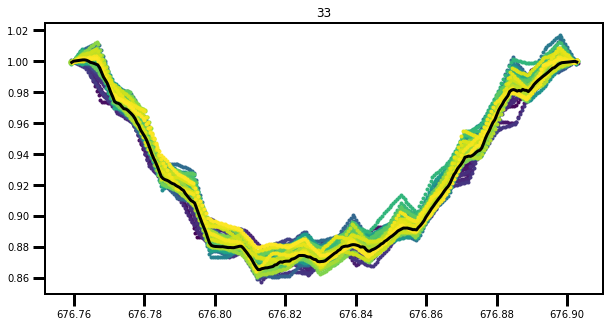

[661.323, 661.484]


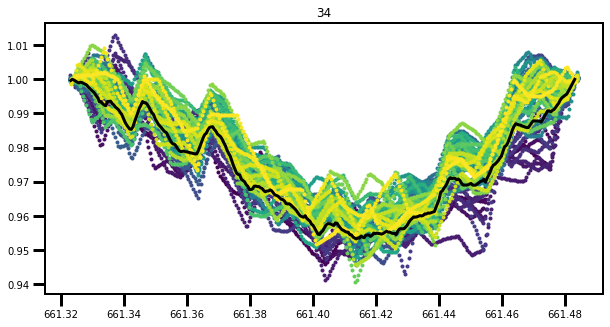

[670.342, 670.466]


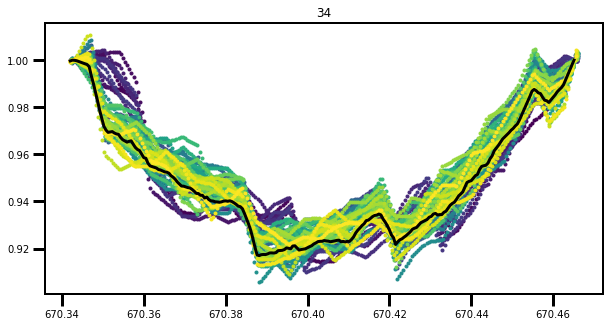

[662.726, 662.878]


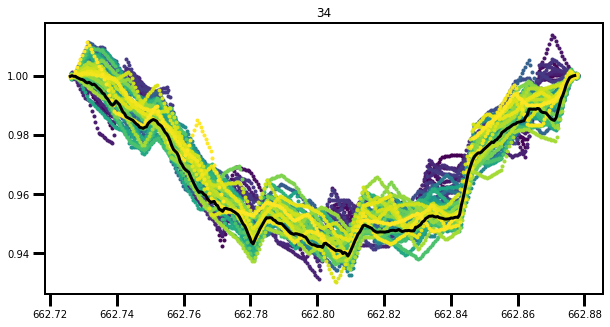

[663.965, 664.102]


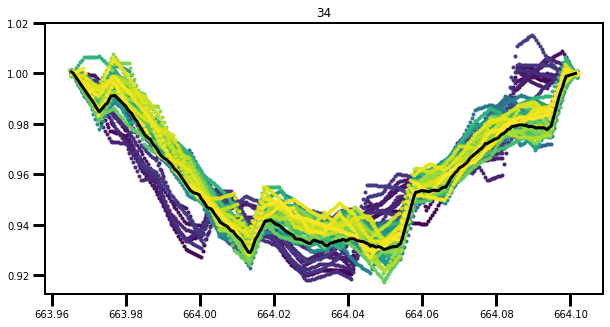

[647.536, 647.687]


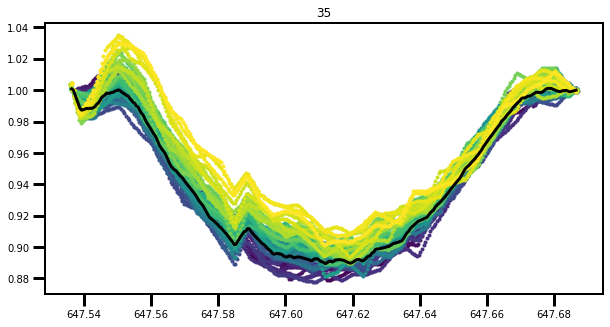

[654.589, 654.745]


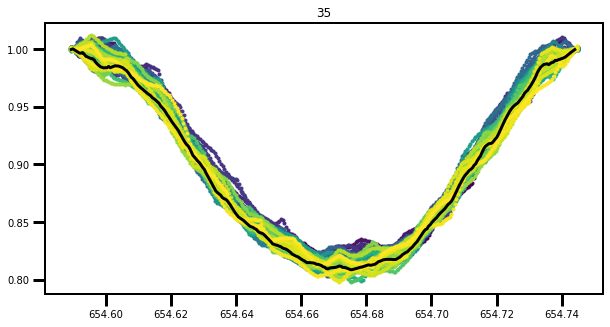

[748.144, 748.351]


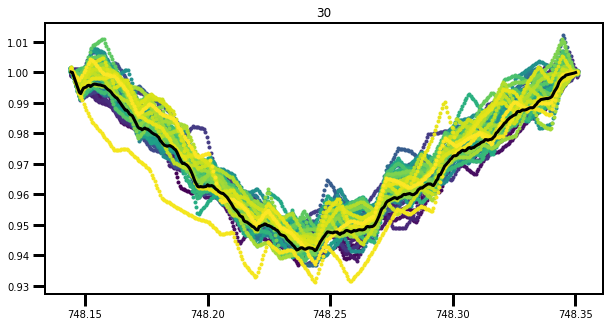

[749.849, 749.999]


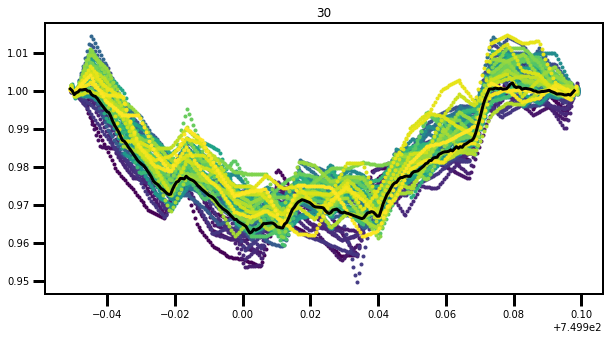

[744.262, 744.462]


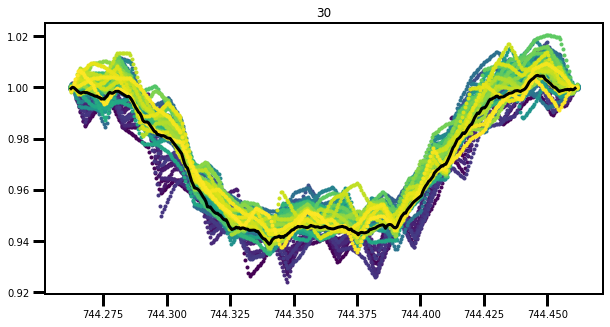

[748.14, 748.374]


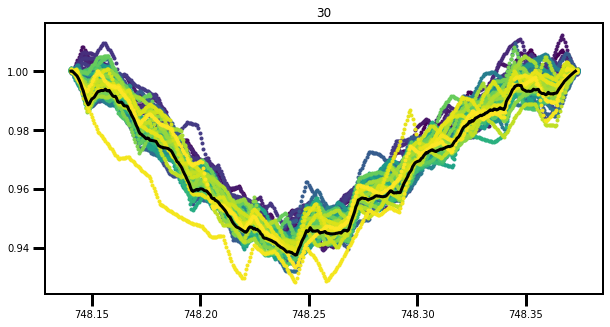

[752.486, 752.657]


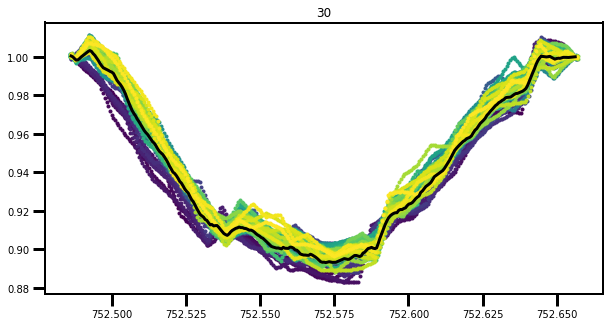

[752.242, 752.438]


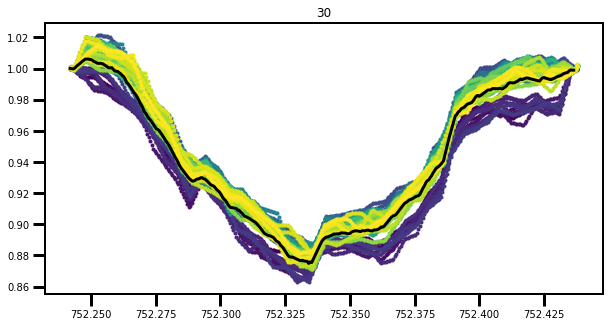

[775.099, 775.242]


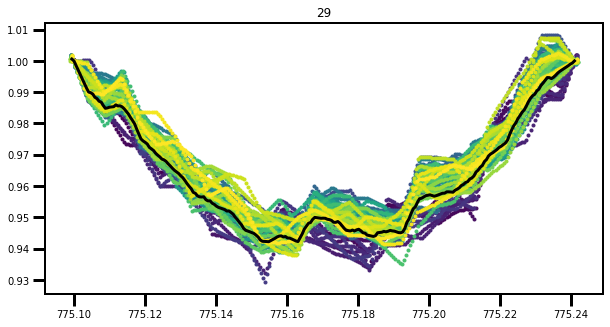

[780.751, 780.935]


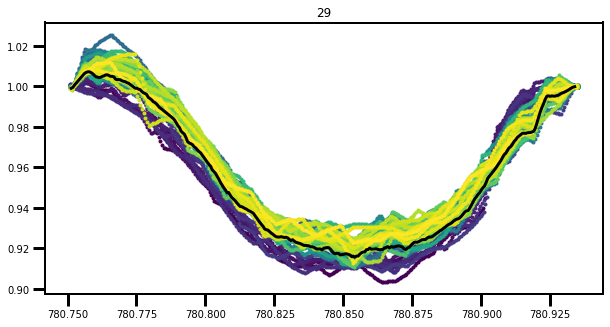

[777.177, 777.354]


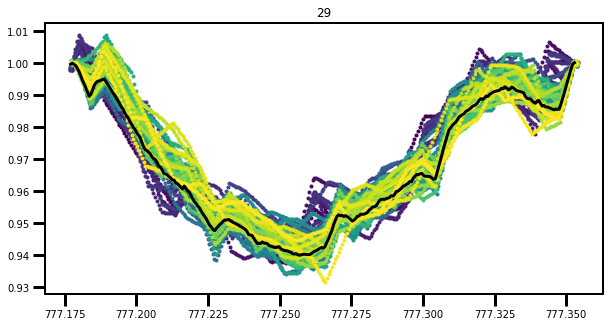

[771.003, 771.178]


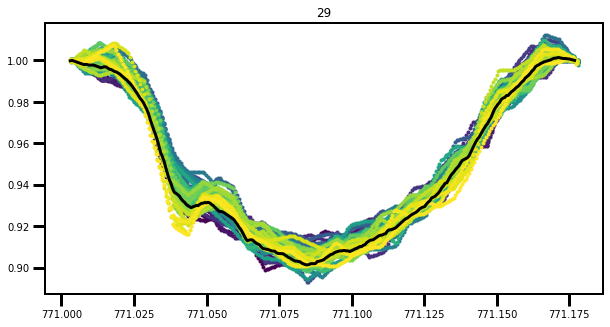

[830.341, 830.491]


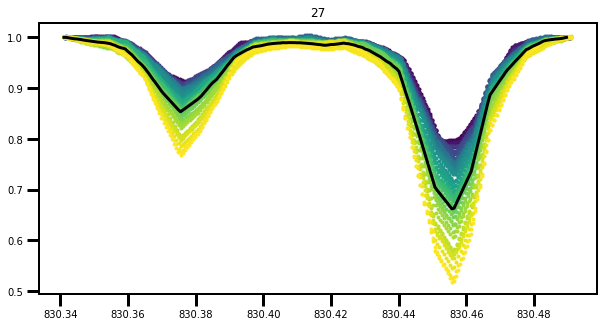

[832.871, 832.953]


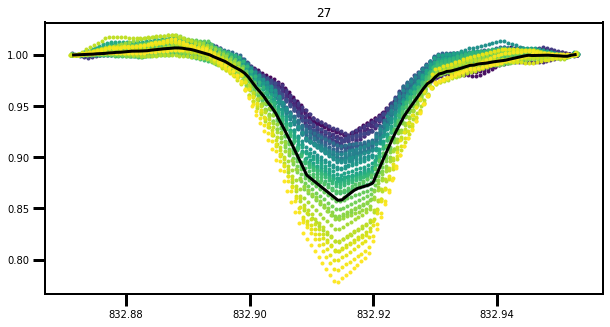

[831.528, 831.609]


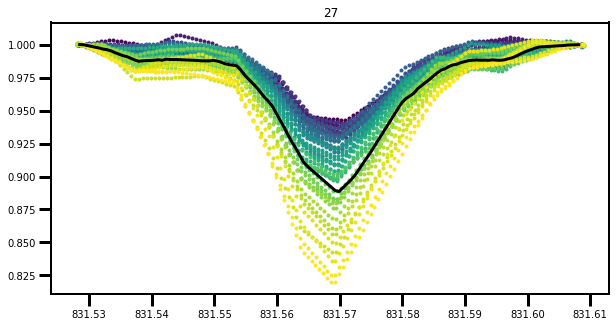

[824.275, 824.316]


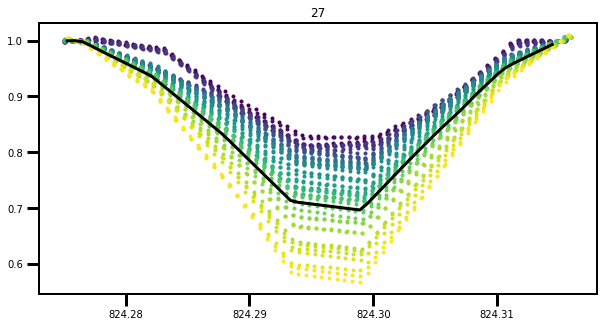

[827.878, 827.939]


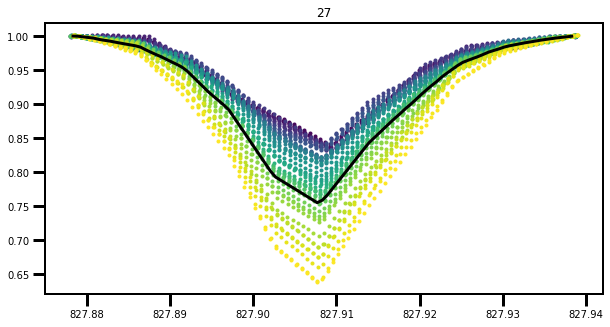

[828.872, 828.927]


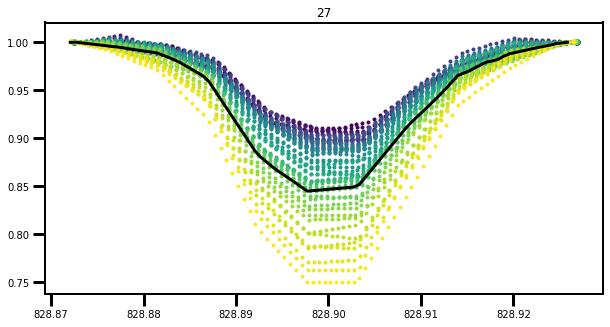

[789.532, 789.575]


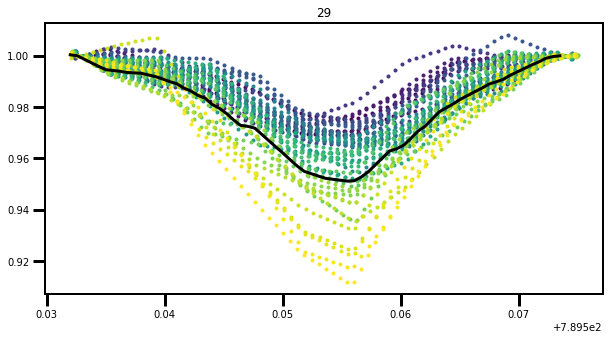

[770.208, 770.251]


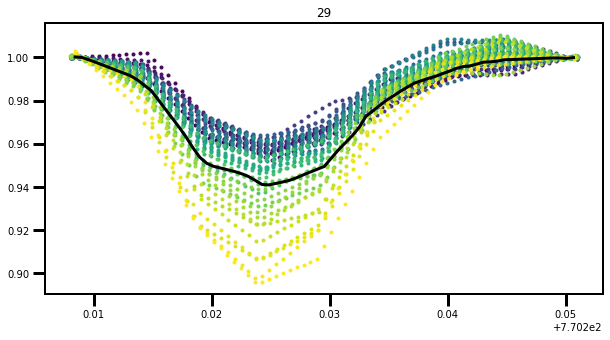

[725.722, 725.774]


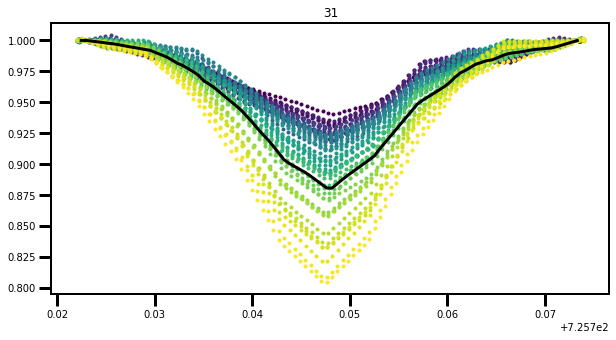

[723.153, 723.204]


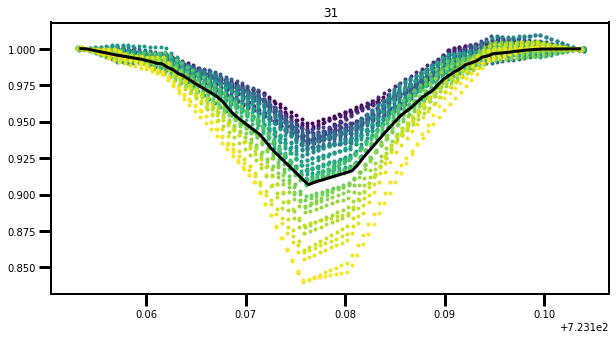

[729.927, 729.967]


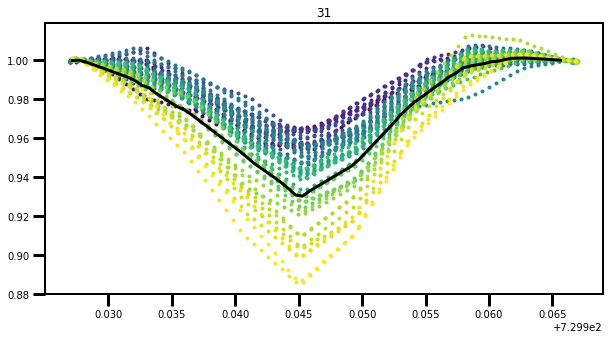

[724.278, 724.359]


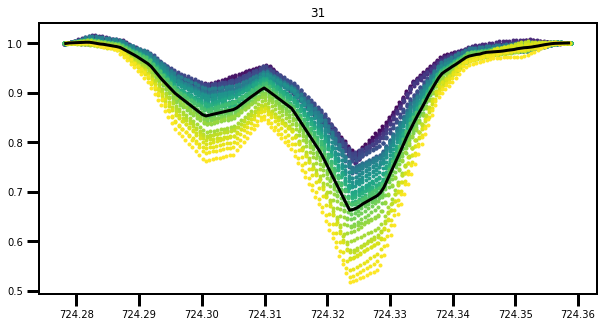

[717.314, 717.344]


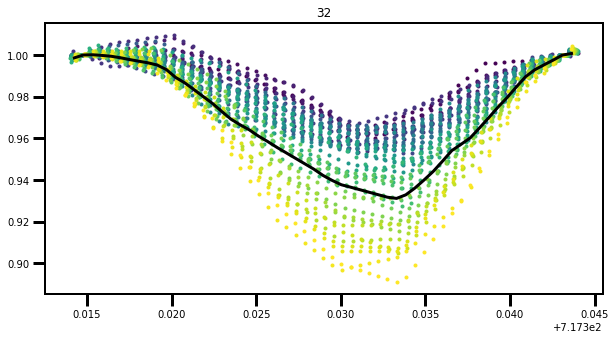

[717.201, 717.261]


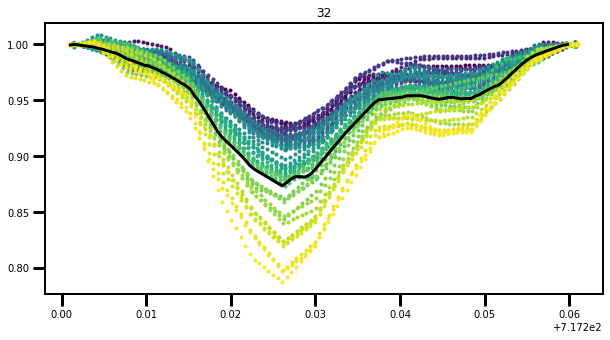

[718.545, 718.612]


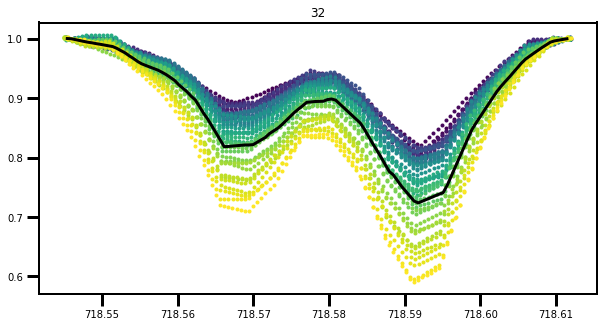

[716.147, 716.181]


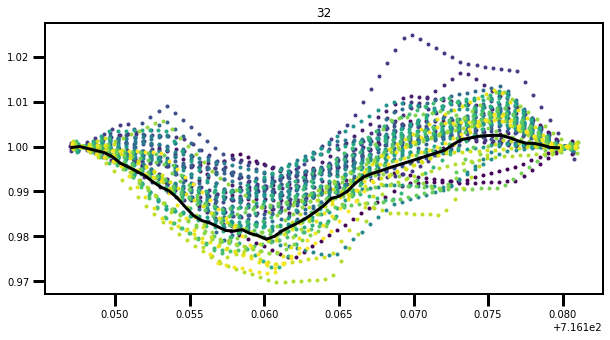

[718.371, 718.433]


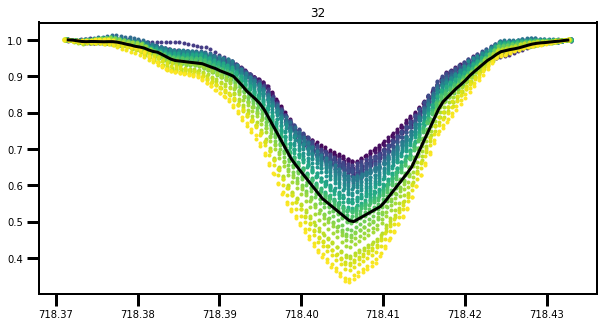

[694.686, 694.73]


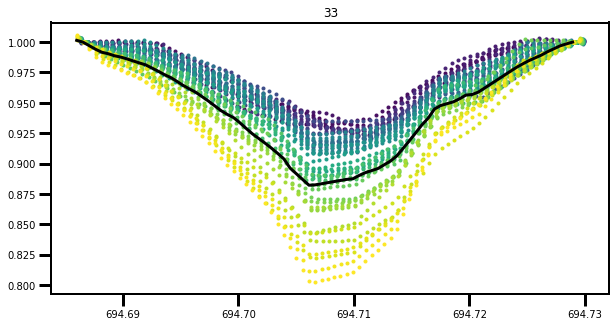

[692.895, 692.932]


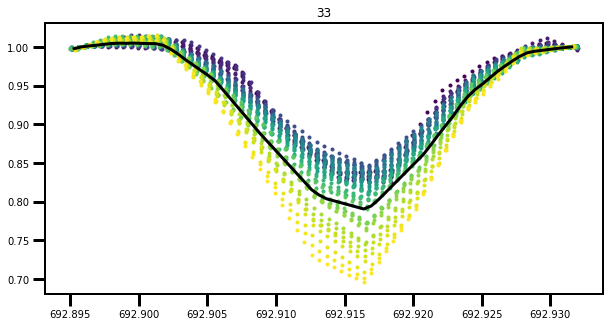

[692.261, 692.312]


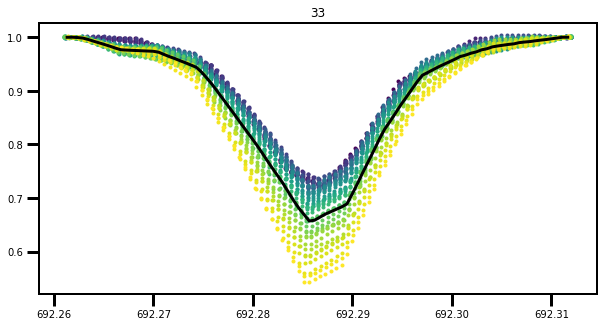

[691.825, 691.886]


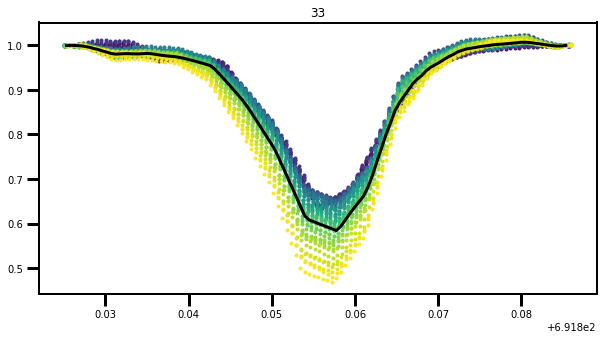

In [24]:
ALL_RVS_STELLAR  = get_rvs_from_lines(stellar_waves, stellar_orders, which='stellar')
ALL_RVS_TELLURIC = get_rvs_from_lines(telluric_waves, telluric_orders)

In [25]:
rv_diffs_stellar  = np.zeros(len(WAVELENGTHS))
rv_diffs_telluric = np.zeros(len(WAVELENGTHS))
for i in range(len(WAVELENGTHS)):
    try:
        rv_diffs_stellar[i] = np.nanmean(ALL_RVS_STELLAR[:,i+1])-np.nanmean(ALL_RVS_STELLAR[:,i])
        rv_diffs_telluric[i] = np.nanmean(ALL_RVS_TELLURIC[:,i+1])-np.nanmean(ALL_RVS_TELLURIC[:,i])
    except IndexError:
        rv_diffs_stellar[i] = np.nanmean(ALL_RVS_STELLAR[:,i])-np.nanmean(ALL_RVS_STELLAR[:,i-1])
        rv_diffs_telluric[i] = np.nanmean(ALL_RVS_TELLURIC[:,i])-np.nanmean(ALL_RVS_TELLURIC[:,i-1])

In [26]:
np.std(rv_diffs_telluric), np.std(rv_diffs_stellar)

(22.93109231046083, 24.594320811242486)

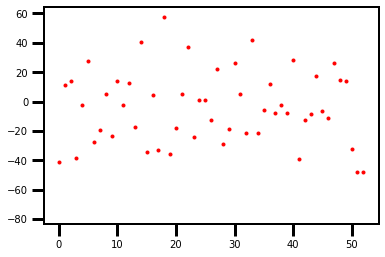

In [27]:
plt.plot(rv_diffs_telluric, 'w.')
plt.plot(rv_diffs_stellar, 'r.')

- Measurement of RVs from tellurics and use as wavelength calibration
- If tellurics are consistent with no motion, then the wavelength is good enough (no correction)
    - Puts limit on the error
- Tests
    - Normalize by airmass
        - <b>Conclusion</b>: Not sure this did a lot in the end
    - Adding in stronger telluric features
        - <b>Conclusion</b>: Adding stronger lines beat down the noise so the std of tellurics < std of stellar lines
    - Looking at stellar lines not in telluric regions
        - <b>Conclusion</b>: Adding more of these look good and also decreased the std of lines
- If happy == True:
    - Do RVs for the full order (minus the junky ends for non telluric dominated ones)
        - Mask wavelengths with significant tellurics (abs > few % in Andreas' model within 0.1 AA)
        - Some people use theoretically modeled spectrum and x-correlate with that
        - Make sure sensible (share same systematics or same astrophysics): consistent across the orders (probably not doing anything that causes a big systematic shift)
    - Waterfall plot
        - Try in the rest frame of each planet (look at Trevor's notes)
    - Look through Trevor's discussion section and can we rule anything out for our data?
  

In [ ]:
# check similarities between tellurics
# check similarities between stellar features

## Mapping tellurics onto spectra & masking

In [294]:
%matplotlib inline

telluric_wave_model = np.array([])
telluric_spec_model = np.array([])

for fn in ['telluric_model_b.hdf', 'telluric_model_r.hdf']:
    f = h5py.File(os.path.join(path1, fn), 'r')
    
    for i, key in enumerate(f['wavelength_solution']['fiber_2'].keys()):
        telluric_wave = f['wavelength_solution']['fiber_2'][key][()]
        telluric_spec = f['telluric_model']['fiber_2'][key][()]

        telluric_wave_model = np.append(telluric_wave_model, telluric_wave)
        telluric_spec_model = np.append(telluric_spec_model, telluric_spec)

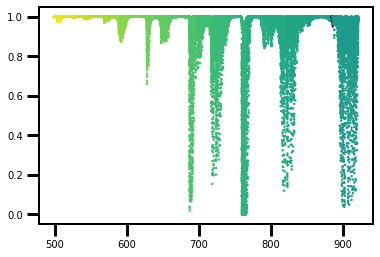

In [315]:
twm, tsm = zip(*sorted(zip(telluric_wave_model, telluric_spec_model)))
twm, tsm = np.array(twm), np.array(tsm) 

tom = np.zeros(len(twm))
for uo in np.unique(ORDERS[0]):
    q = ORDERS[0] == uo
    start = WAVELENGTHS[0][q][0]
    end = WAVELENGTHS[0][q][-1]
    tom[ (twm >= start) & (twm <= end) ] = uo
plt.scatter(twm, tsm, c=tom, s=2)

twm = np.delete(twm, np.where(tom==0)[0])
tsm = np.delete(tsm, np.where(tom==0)[0])
tom = np.delete(tom, np.where(tom==0)[0])

In [192]:
def group_inds(values):
    results = []
    
    for i, v in enumerate(values):
        if i == 0:
            mini = maxi = v
            temp = [v]
        else:
            if (np.abs(v-maxi) <= 5):
                temp.append(v)
                if v > maxi:
                    maxi = v
                if v < mini:
                    mini = v
            else:
                results.append(temp)
                mini = maxi = v
                temp = [v]               
                
            if i == len(values)-1:
                results.append(temp)
    return np.array(results)

## Binary Mask

## Masking tellurics

In [418]:
telluric_limit = 0.990
cutends = 2500

In [612]:
cleaned_w = np.zeros(len(WAVELENGTHS), dtype=np.ndarray)
cleaned_s = np.zeros(len(WAVELENGTHS), dtype=np.ndarray)
cleaned_o = np.zeros(len(WAVELENGTHS), dtype=np.ndarray)

for i in range(len(WAVELENGTHS)):
    tempw, temps, tempo = np.array([]), np.array([]), np.array([])
    
    for uo in np.unique(ORDERS[i]):
        q = ORDERS[i] == uo
        wave = WAVELENGTHS[i][q][cutends:-cutends]
        spec = SPECTRA[i][q][cutends:-cutends]
        ordr = ORDERS[i][q][cutends:-cutends]
        
        where_model = np.where(((tom==uo) | (tom==uo+1)) &
                                (twm >= wave[0]) &
                                (twm <= wave[-1]))[0]

        if len(where_model):
            bad_tell = np.where(tsm[where_model] < telluric_limit)[0]

            if len(bad_tell):
                argoffset = np.argmin(tsm[where_model][bad_tell])
                find_feature = np.where((wave <= twm[where_model][bad_tell][argoffset]+0.05) &
                                        (wave >= twm[where_model][bad_tell][argoffset]-0.4))[0]
                argmatch = np.argmin(spec[find_feature])
                offset = twm[where_model][bad_tell][argoffset] - wave[find_feature][argmatch]

                groups = group_inds(bad_tell)
                mask = np.ones(len(wave), dtype=bool)

                for g in groups:
                    ind = np.where((wave >= twm[where_model][g[0]]-0.05) &
                                   (wave <= twm[where_model][g[-1]]+0.05))[0]
                    mask[ind] = 0
                if len(wave[mask])/len(wave) > 0.75:
                    tempw = np.append(tempw, wave[mask])
                    temps = np.append(temps, spec[mask])
                    tempo = np.append(tempo, ordr[mask])

        else:
            wave = WAVELENGTHS[i][q][cutends:-cutends]
            spec = SPECTRA[i][q][cutends:-cutends]
            ordr = ORDERS[i][q][cutends:-cutends]
            tempw = np.append(tempw, wave)
            temps = np.append(temps, spec)
            tempo = np.append(tempo, ordr)
    cleaned_w[i] = tempw
    cleaned_s[i] = temps
    cleaned_o[i] = tempo

In [613]:
def running_slider(wave, flux, window_length=51, percentile=99):
    bins = np.arange(0,len(flux),window_length)
    bins = np.append(bins, len(flux)-1)
    
    run_w = np.zeros(len(bins)-1)
    run_f = np.zeros(len(bins)-1)
    
    for i in range(len(bins)-1):
        start = bins[i]
        end = bins[i+1]
        
        run_w[i] = np.nanmedian(wave[start:end])
        run_f[i] = np.nanpercentile(flux[start:end], percentile)
        
    run_w = np.append(wave[0], run_w)
    run_f = np.append(flux[0], run_f)
    run_w = np.append(run_w, wave[-1])
    run_f = np.append(run_f, flux[-1])
    return run_w, run_f

### What to do next
- Get those orders topped (continuum) at 1, not anything more than that <b>##Done##</b>
- Try cutting to only high SNR orders <b>##Done##</b>
    1. Removed all orders that were predominantly masked 
    2. Removed last 9 orders that looked like garbage
- something weighted? weighted mean? something something?
- start looking at starry models <b>##Started##</b>
    - put in the known planet parameters, without spots, to gain intuition 
    - could bump at 0.85 be egress for c? is the bump strong enough?
- look at H-alpha feature

### RV Uncertainty
- standard deviation of the orders, weighted based on how much information they believe is in each chunk
- jitter term will probs dominate over formal uncertainties
- otherwise, nbd (as long as it looks _reasonable_ )


### Take a suspicious order
- Follow every step until x-correlation 
    - Do the raw data look different?
        - If they look different, womp womp nothing we can do about it
        - <b>##There's nothing obvious to me here##</b>
    - Am I injecting something weird?
        - If there is -- don't do it
        - If there isn't -- see above
    
    - Use tellurics to recover the drift of the instrument (see if there's anything to recover)
        - x-correlate with Andreas' template (rather than a median)
    - Try x-correlating with the ESPRESSO binary template
    - Spread per order (uncertainty) and if there's a systematic offset between orders
    - Try x-correlating smaller chunks

## Cross correlating tellurics

In [574]:
telluric_orders = np.array([])
for o in np.unique(ORDERS[0]):
    if o not in np.unique(cleaned_o[0]):
        telluric_orders = np.append(telluric_orders, o)
telluric_orders

array([25., 27., 28., 29., 30., 31., 32., 33., 35., 38., 43.])

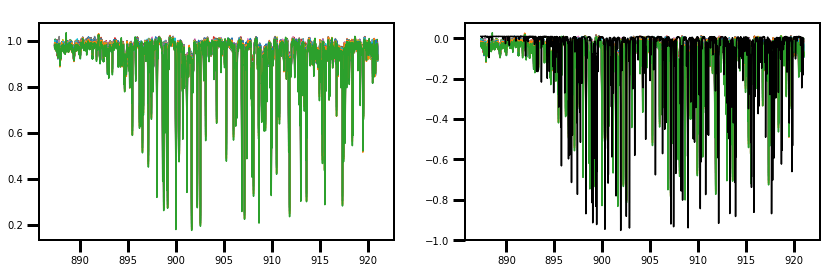

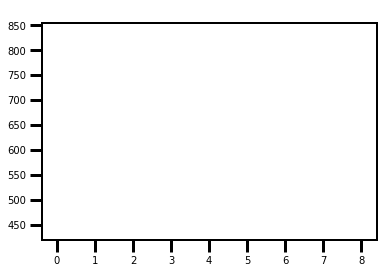

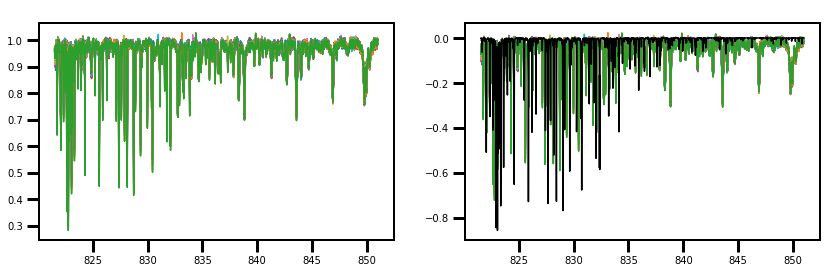

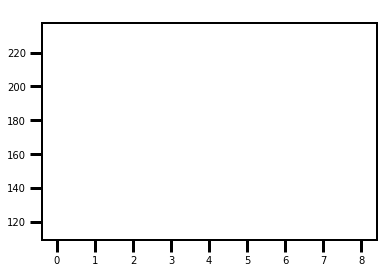

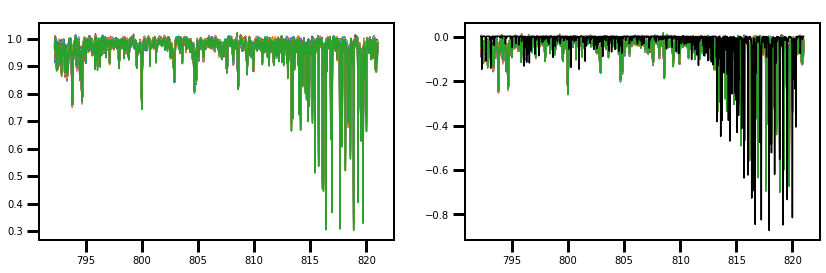

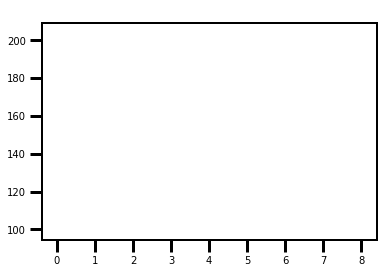

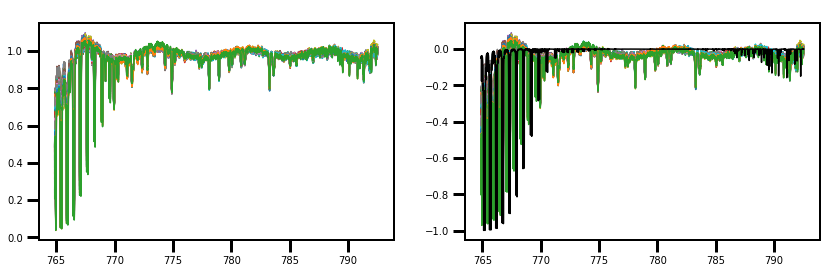

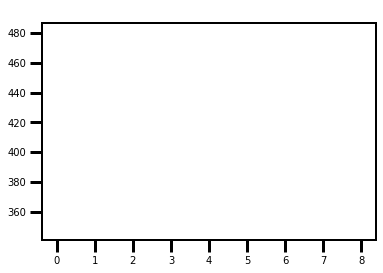

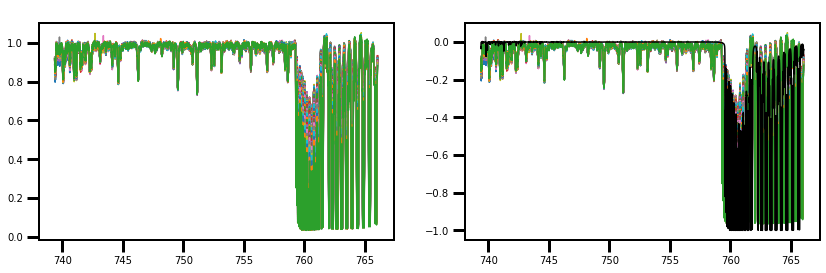

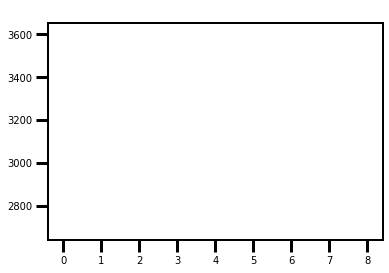

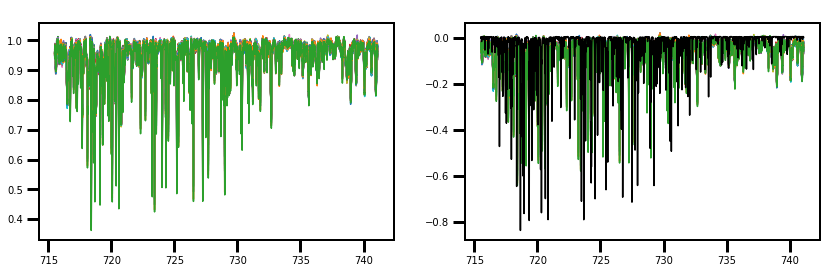

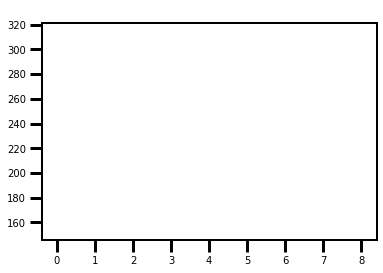

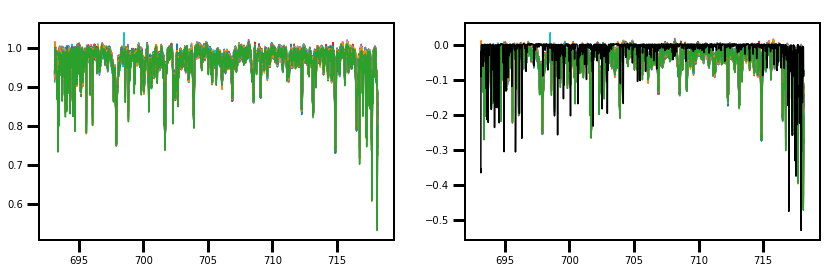

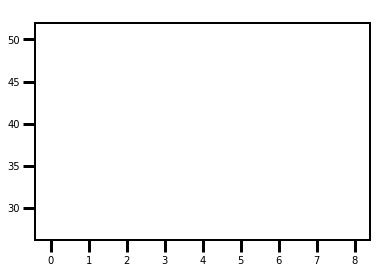

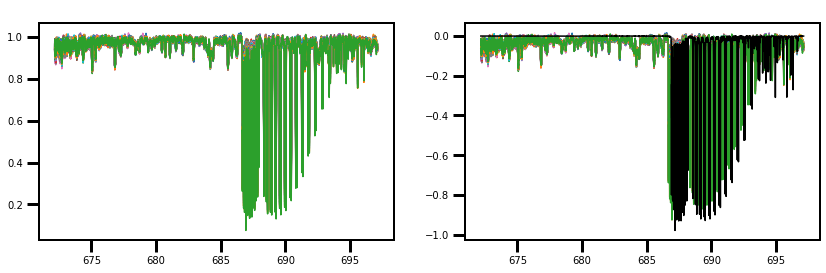

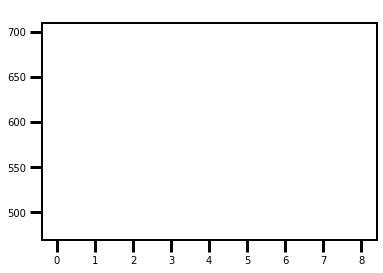

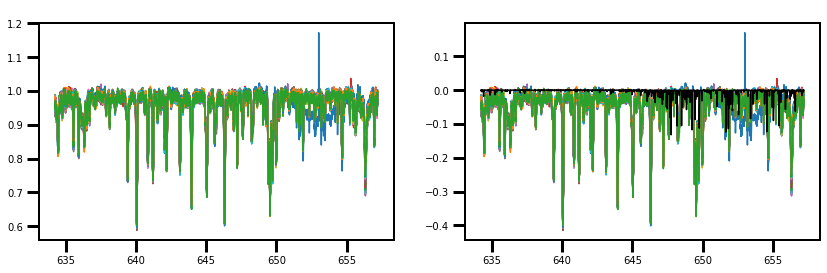

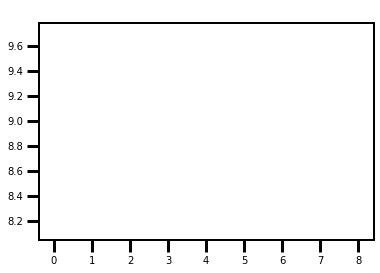

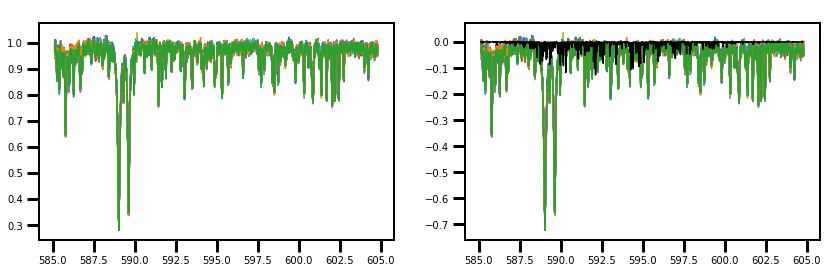

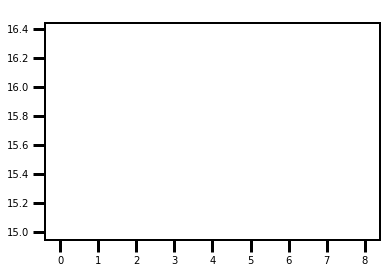

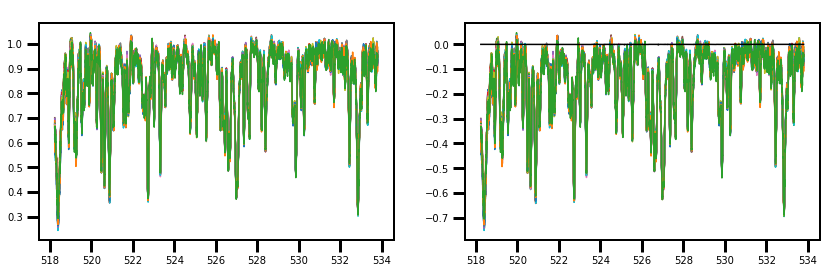

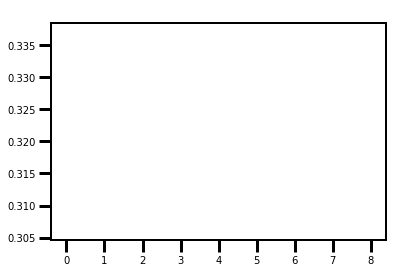

In [582]:
lens = []
avg_tell_rv = np.zeros(len(np.unique(cleaned_o[0])))
all_tell_peaks = np.zeros( (len(np.unique(cleaned_o[0])), len(cleaned_o)) )
%matplotlib inline

for j, order in enumerate(telluric_orders):
    for i in range(len(WAVELENGTHS)):
        q = ORDERS[i] == order
        lens.append(len(WAVELENGTHS[i][q][wl:-wl]))

    length = np.nanmin(lens)
    #length = 3000
    equal_spectra = np.zeros((len(WAVELENGTHS), length))
    equal_waves   = np.zeros((len(WAVELENGTHS), length))
    equal_orders  = np.zeros((len(WAVELENGTHS), length))
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    
    for i in range(len(cleaned_w)):
        q = (ORDERS[i] == order)
        diff = np.abs(len(WAVELENGTHS[i][q]) - np.nanmin(lens))
        if diff > 0:
            if diff == 1:
                co = ORDERS[i][q][1:]
                cw = WAVELENGTHS[i][q][1:]
                cs = SPECTRA[i][q][1:]
            else:
                if diff % 2 == 0:
                    co = ORDERS[i][q][int(diff/2):-int(diff/2)]
                    cw = WAVELENGTHS[i][q][int(diff/2):-int(diff/2)]
                    cs = SPECTRA[i][q][int(diff/2):-int(diff/2)]
                else:
                    co = ORDERS[i][q][int(diff/2):-int(diff/2)-1]
                    cw = WAVELENGTHS[i][q][int(diff/2):-int(diff/2)-1]
                    cs = SPECTRA[i][q][int(diff/2):-int(diff/2)-1]
        else:
            co = ORDERS[i][q]
            cw = WAVELENGTHS[i][q]
            cs = SPECTRA[i][q]

        wl = 1507
        run_w, run_s = running_slider(cw, cs, 
                                      percentile=100, 
                                      window_length=wl)
        fit = np.polyfit(run_w, run_s, deg=2)
        model = np.poly1d(fit)
        interp = interp1d(run_w, run_s)
        
        #cs /= interp(cw)
        ax1.plot(cw[int(len(cs)/2-length/2):int(len(cs)/2+length/2)], 
                 cs[int(len(cs)/2-length/2):int(len(cs)/2+length/2)])
        
        cs -= np.nanmedian(interp(cw))
        
        ax2.plot(cw[int(len(cs)/2-length/2):int(len(cs)/2+length/2)], 
                 cs[int(len(cs)/2-length/2):int(len(cs)/2+length/2)])
        ax2.set_title(np.nanmax(interp(cw)))
        equal_spectra[i] = cs[int(len(cs)/2-length/2):int(len(cs)/2+length/2)]
        equal_orders[i]  = co[int(len(cs)/2-length/2):int(len(cs)/2+length/2)]
        equal_waves[i]   = cw[int(len(cs)/2-length/2):int(len(cs)/2+length/2)]
        
    #temp_reg = np.where((twm>=cw[0]) & (twm<=cw[-1]))[0]
    interp = interp1d(twm, tsm)
    template = interp(cw)
    plt.plot(cw, template-np.nanmedian(template), 'k')
    
    #plt.xlim(865, 870)
    plt.show()

    peaks = np.zeros(len(equal_spectra))
    
    for i in range(len(equal_orders)):
        q = equal_orders[i] == order
        subwave = equal_waves[i][q] + 0.0
        corr = np.correlate(template[q] - np.nanmedian(template[q]),
                            equal_spectra[i][q], #- np.nanmedian(equal_spectra[i][q]),
                            mode='same')
        c_x = np.arange(np.argmax(corr)-4, np.argmax(corr)+5,1,dtype=int)
        fit = np.polyfit(c_x-np.argmax(corr), corr[c_x], deg=2)
        maximum = -fit[1]/(2*fit[0])
        peaks[i] = maximum
        plt.plot(corr[c_x], 'w')
    all_tell_peaks[j] = peaks

    rv = np.nanmedian(np.diff(np.log(subwave))) * 3e8 * peaks
    avg_tell_rv[j] = np.median(rv)
    plt.title(order)
    plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.


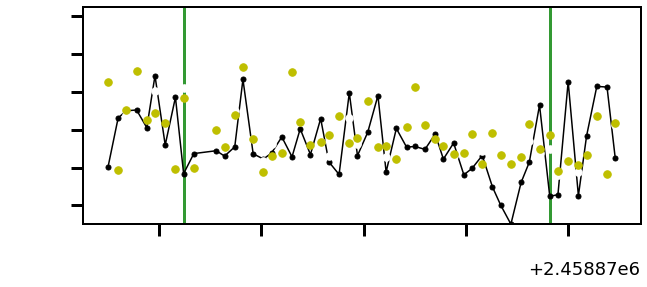

In [604]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10,4))

tell_med2 = np.nanmedian(np.delete(all_tell_peaks[:-12],[3,8,11], axis=0),
                   axis=0)

plt.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med1, 'k', ms=5)
plt.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med1, 'k.', ms=10)

tell_med = np.nanmedian(all_tell_peaks[:-12], axis=0)
tell_mean = np.nanmean(all_tell_peaks[:-12], axis=0)

plt.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * tell_med, 'w.', ms=15)
plt.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * tell_mean, 'y.', ms=15)

plt.vlines(TIMES[BOTH[-1]], -100,100, color='g', lw=3, alpha=0.8)
plt.vlines(TIMES[TRANSIT_C[-1]], -100,100, color='g', lw=3, alpha=0.8)

plt.ylim(-50,65)
plt.xticks(color='w')
plt.yticks(color='w')
plt.xlabel('Time', color='w')
plt.ylabel('RVs [m/s]', color='w');

In [887]:
def inject_rv(wave, rv, remove=False):
    c = 3e8 * u.m / u.s
    rv = rv * u.m / u.s
    wave = wave * u.nm
    factor = rv/c
    
    log_delta_wave = np.log(rv.value) - np.log(c.value) + np.log(wave.value)
    
    delta_wave = factor*wave
    
    if remove == False:
        return wave + delta_wave
    else:
        return wave - delta_wave

In [806]:
telluric_rvs = np.nanmedian(np.diff(np.log(subwave))) * 3e8 * tell_med
WAVELENGTHS_REMOVED = np.copy(WAVELENGTHS)
for i in range(len(ORDERS)):
    WAVELENGTHS_REMOVED[i] = remove_rv(WAVELENGTHS[i], telluric_rvs[i])

In [807]:
cleaned_w = np.zeros(len(WAVELENGTHS_REMOVED), dtype=np.ndarray)
cleaned_s = np.zeros(len(WAVELENGTHS_REMOVED), dtype=np.ndarray)
cleaned_o = np.zeros(len(WAVELENGTHS_REMOVED), dtype=np.ndarray)

for i in range(len(WAVELENGTHS_REMOVED)):
    tempw, temps, tempo = np.array([]), np.array([]), np.array([])
    
    for uo in np.unique(ORDERS[i]):
        q = ORDERS[i] == uo
        wave = WAVELENGTHS_REMOVED[i][q][cutends:-cutends]
        spec = SPECTRA[i][q][cutends:-cutends]
        ordr = ORDERS[i][q][cutends:-cutends]
        
        where_model = np.where(((tom==uo) | (tom==uo+1)) &
                                (twm >= wave[0]) &
                                (twm <= wave[-1]))[0]

        if len(where_model):
            bad_tell = np.where(tsm[where_model] < telluric_limit)[0]

            if len(bad_tell):
                argoffset = np.argmin(tsm[where_model][bad_tell])
                find_feature = np.where((wave <= twm[where_model][bad_tell][argoffset]+0.05) &
                                        (wave >= twm[where_model][bad_tell][argoffset]-0.4))[0]
                argmatch = np.argmin(spec[find_feature])
                offset = twm[where_model][bad_tell][argoffset] - wave[find_feature][argmatch]

                groups = group_inds(bad_tell)
                mask = np.ones(len(wave), dtype=bool)

                for g in groups:
                    ind = np.where((wave >= twm[where_model][g[0]]-0.05) &
                                   (wave <= twm[where_model][g[-1]]+0.05))[0]
                    mask[ind] = 0
                if len(wave[mask])/len(wave) > 0.75:
                    tempw = np.append(tempw, wave[mask])
                    temps = np.append(temps, spec[mask])
                    tempo = np.append(tempo, ordr[mask])

        else:
            wave = WAVELENGTHS_REMOVED[i][q][cutends:-cutends]
            spec = SPECTRA[i][q][cutends:-cutends]
            ordr = ORDERS[i][q][cutends:-cutends]
            tempw = np.append(tempw, wave)
            temps = np.append(temps, spec)
            tempo = np.append(tempo, ordr)
    cleaned_w[i] = tempw
    cleaned_s[i] = temps
    cleaned_o[i] = tempo

## Stellar line cross correlation

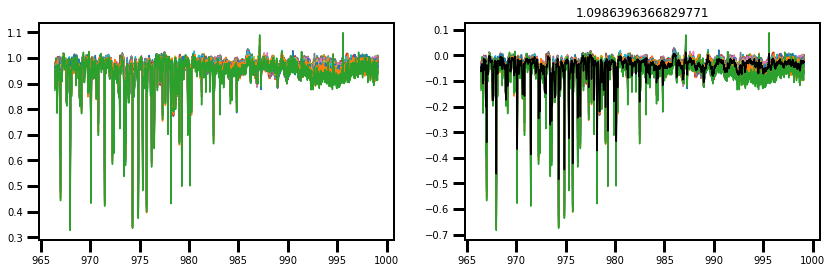

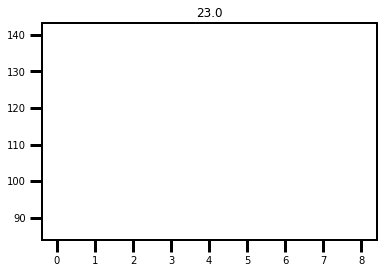

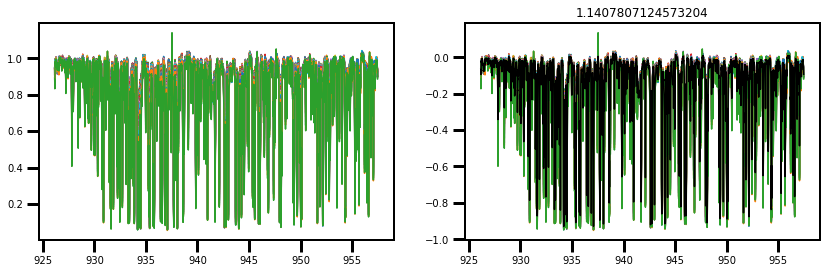

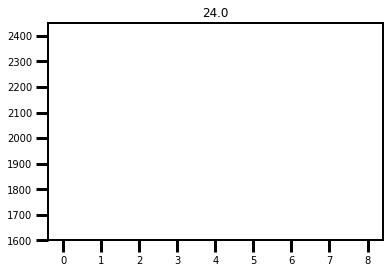

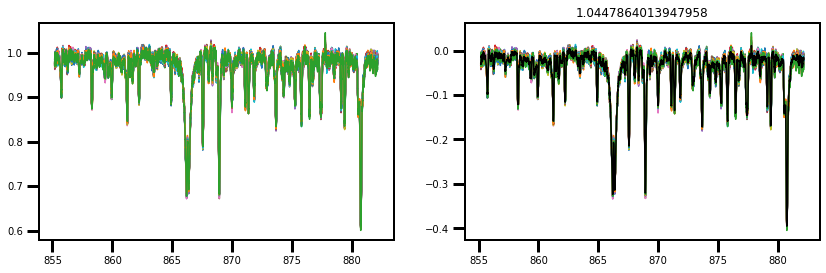

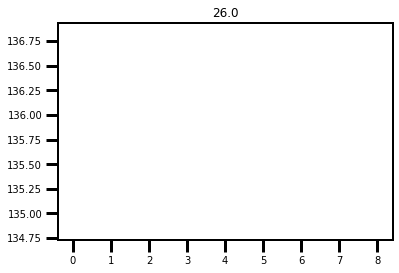

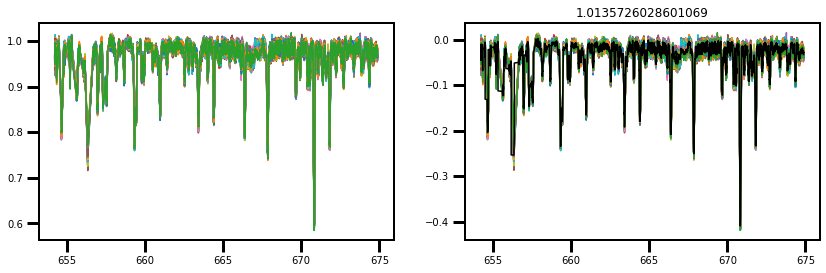

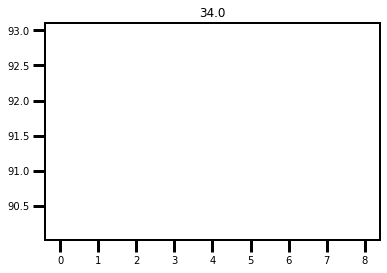

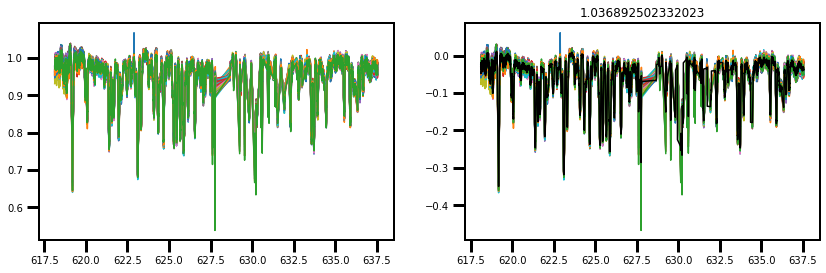

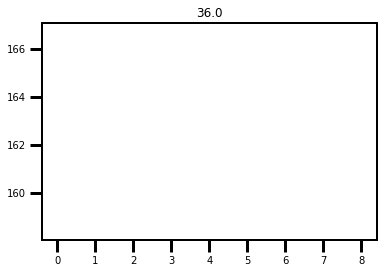

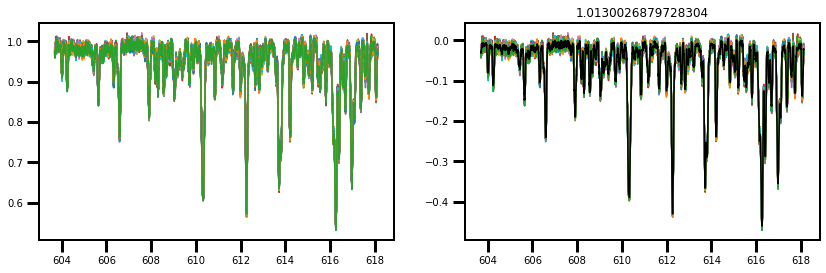

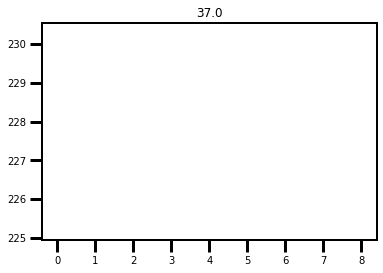

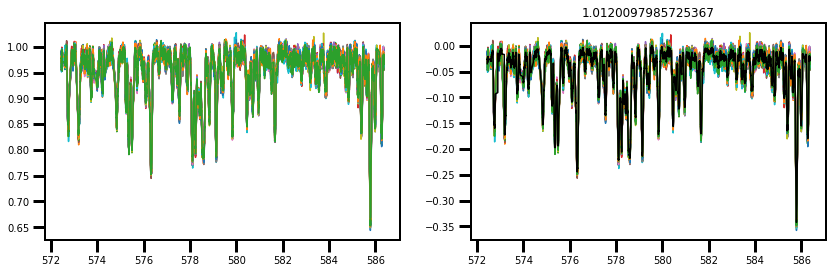

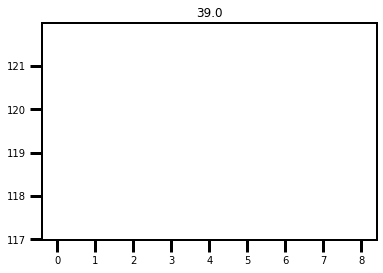

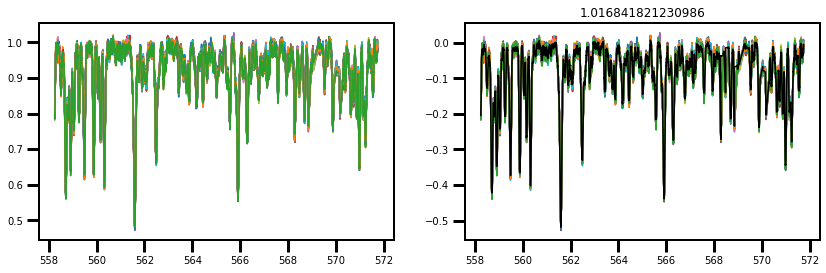

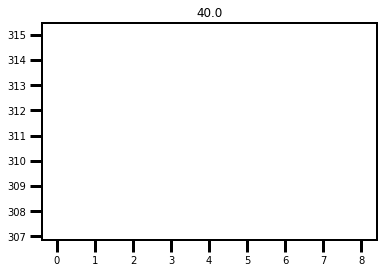

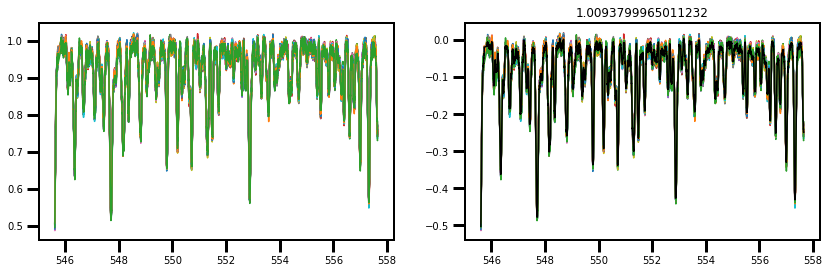

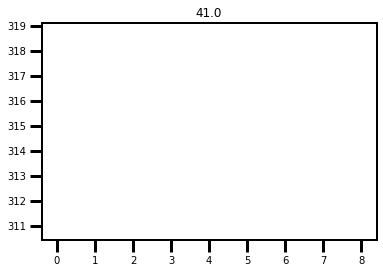

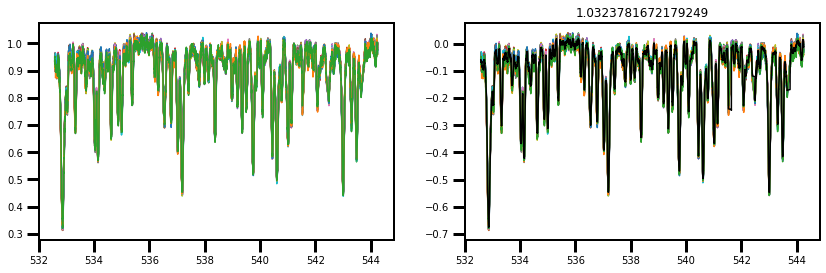

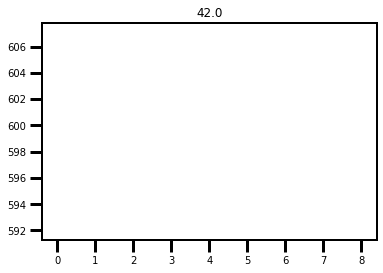

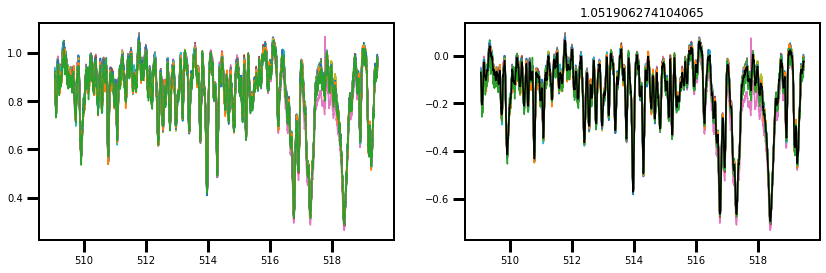

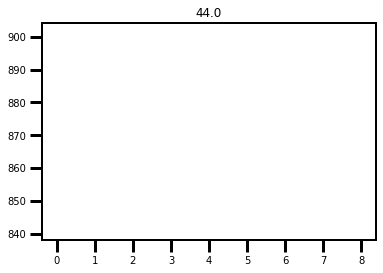

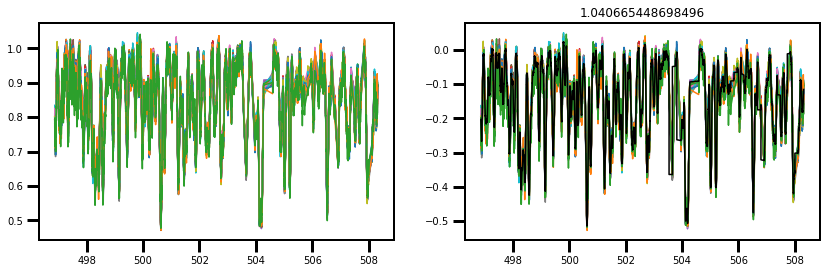

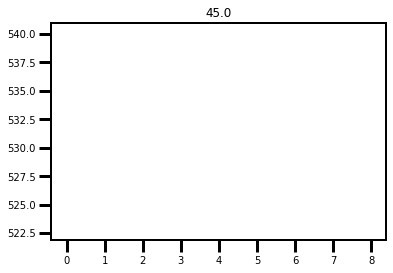

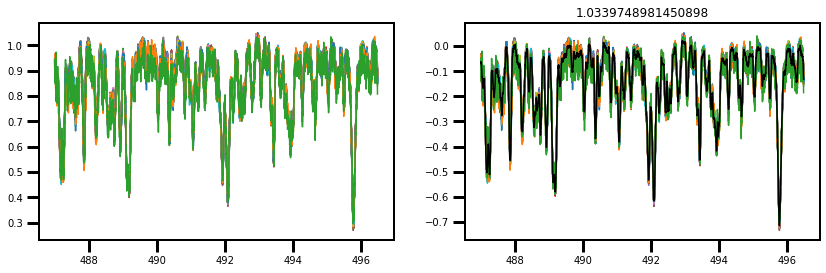

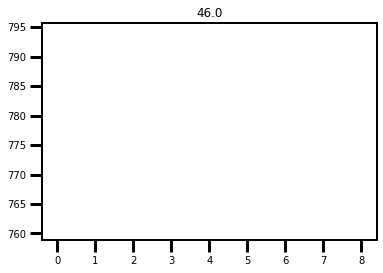

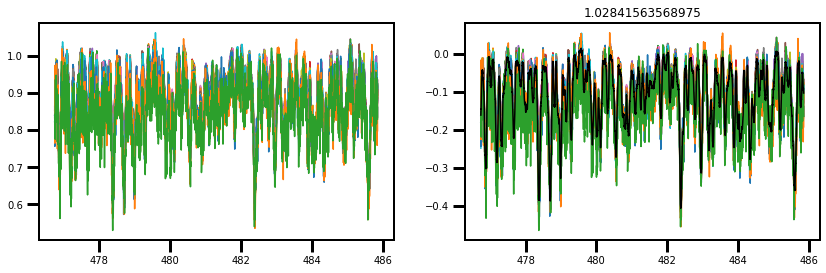

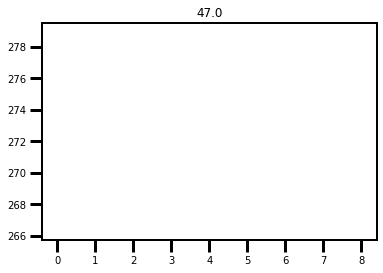

In [808]:
lens = []
avg_rv = np.zeros(len(np.unique(cleaned_o[0])))
all_peaks = np.zeros( (len(np.unique(cleaned_o[0])), len(cleaned_o)) )
%matplotlib inline

for j, order in enumerate(np.unique(cleaned_o[0])[:-9]):
    for i in range(len(cleaned_w)):
        q = cleaned_o[i] == order
        lens.append(len(cleaned_w[i][q][wl:-wl]))

    length = np.nanmin(lens)
    #length = 3000
    equal_spectra = np.zeros((len(cleaned_w), length))
    equal_waves   = np.zeros((len(cleaned_w), length))
    equal_orders  = np.zeros((len(cleaned_w), length))
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))

    for i in range(len(cleaned_w)):
        q = (cleaned_o[i] == order)
        diff = np.abs(len(cleaned_w[i][q]) - np.nanmin(lens))
        if diff > 0:
            if diff == 1:
                co = cleaned_o[i][q][1:]
                cw = cleaned_w[i][q][1:]
                cs = cleaned_s[i][q][1:]
            else:
                if diff % 2 == 0:
                    co = cleaned_o[i][q][int(diff/2):-int(diff/2)]
                    cw = cleaned_w[i][q][int(diff/2):-int(diff/2)]
                    cs = cleaned_s[i][q][int(diff/2):-int(diff/2)]
                else:
                    co = cleaned_o[i][q][int(diff/2):-int(diff/2)-1]
                    cw = cleaned_w[i][q][int(diff/2):-int(diff/2)-1]
                    cs = cleaned_s[i][q][int(diff/2):-int(diff/2)-1]
        else:
            co = cleaned_o[i][q]
            cw = cleaned_w[i][q]
            cs = cleaned_s[i][q]

        wl = 1507
        run_w, run_s = running_slider(cw, cs, 
                                      percentile=100, 
                                      window_length=wl)
#        fit = np.polyfit(run_w, run_s, deg=2)
#        model = np.poly1d(fit)
        interp = interp1d(run_w, run_s)

        #cs /= interp(cw)
        ax1.plot(cw[int(len(cs)/2-length/2):int(len(cs)/2+length/2)], 
                 cs[int(len(cs)/2-length/2):int(len(cs)/2+length/2)])

        cs -= np.nanmedian(interp(cw))

        ax2.plot(cw[int(len(cs)/2-length/2):int(len(cs)/2+length/2)], 
                 cs[int(len(cs)/2-length/2):int(len(cs)/2+length/2)])
        ax2.set_title(np.nanmax(interp(cw)))
        equal_spectra[i] = cs[int(len(cs)/2-length/2):int(len(cs)/2+length/2)]
        equal_orders[i]  = co[int(len(cs)/2-length/2):int(len(cs)/2+length/2)]
        equal_waves[i]   = cw[int(len(cs)/2-length/2):int(len(cs)/2+length/2)]

    template = np.nanpercentile(equal_spectra, 50, axis=0)
    plt.plot(cw, template, 'k')


    #plt.xlim(865, 870)
    plt.show()

    peaks = np.zeros(len(equal_spectra))

    for i in range(len(equal_orders)):
        q = equal_orders[i] == order
        subwave = equal_waves[i][q] + 0.0
        corr = np.correlate(template[q] - np.nanmedian(template[q]),
                            equal_spectra[i][q], #- np.nanmedian(equal_spectra[i][q]),
                            mode='same')
        c_x = np.arange(np.argmax(corr)-4, np.argmax(corr)+5,1,dtype=int)
        fit = np.polyfit(c_x-np.argmax(corr), corr[c_x], deg=2)
        maximum = -fit[1]/(2*fit[0])
        peaks[i] = maximum
        plt.plot(corr[c_x], 'w')
    all_peaks[j] = peaks
    rv = np.nanmedian(np.diff(np.log(subwave))) * 3e8 * peaks
    avg_rv[j] = np.median(rv)
    plt.title(order)
    plt.show()

In [530]:
from lightkurve.lightcurve import LightCurve as LC
plt.rcParams['text.color'] = 'white'

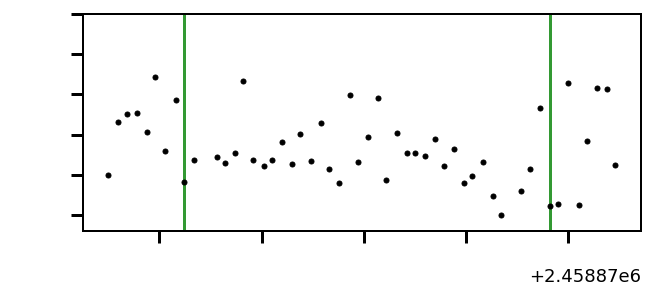

In [874]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10,4))

remove = np.append(np.arange(len(all_peaks)-10,len(all_peaks),1,dtype=int),
                   [1, 8])

med3 = np.nanmedian(np.delete(all_peaks[:-10],[3,8,11], axis=0),
                   axis=0)

plt.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med2, 'k.', ms=10)
#plt.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med3, 'w.', ms=10)

med = np.nanmedian(all_peaks[:-10], axis=0)
mean = np.nanmean(all_peaks[:-10], axis=0)

plt.vlines(TIMES[BOTH[-1]], -100,100, color='g', lw=3, alpha=0.8)
plt.vlines(TIMES[TRANSIT_C[-1]], -100,100, color='g', lw=3, alpha=0.8)

plt.ylim(-60,75)
plt.xticks(color='w')
plt.yticks(color='w')
plt.xlabel('Time', color='w')
plt.ylabel('RVs [m/s]', color='w');

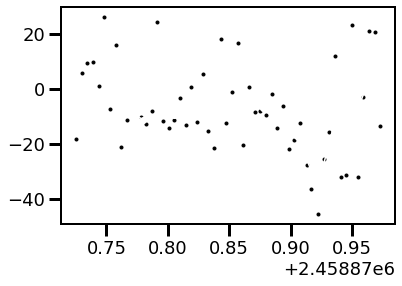

In [836]:
lk = LC(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med2)

plt.plot(lk.time, lk.flux, 'k.')
plt.plot(lk.bin(bins=int(53/3)).time, lk.bin(bins=int(53/3)).flux, 'wo')
plt.plot(lk.bin(bins=int(53/3)).time, lk.bin(bins=int(53/3)).flux, 'w')

In [686]:
for i, uo in enumerate(np.unique(cleaned_o[0])):
    q = cleaned_o[0] == uo
    subwave = cleaned_w[0][q] 
    rv = np.nanmedian(np.diff(np.log(subwave))) * 3e8 * all_peaks[i]
    #plt.plot(rv, 'w.')
    #plt.title('{},{}'.format(np.nanmin(subwave), np.nanmax(subwave)))
    #plt.show()

# Cross correlation with binary mask

In [1005]:
from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, len(np.unique(ORDERS[0])))
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

In [876]:
binary = np.load('k2_mask.npy', allow_pickle=True)

- Binary mask in rest wavelength
- Star has activity RV (16.15 km / s)

## Step 1: Tellurics
- Inject RV shift from -16200 to 16200 m/s (roughly)
- Interpolate real spectrum onto binary weighted spectrum grid
- Sum(Binary * interpolated spectrum)
- Likelihood output as a function of shift
- Fit parabola to peak of likelihood (just as b4)

## Step 2: repeat step 1 for stellar lines

###### * Pay attention to systematics in the mask (offsets in the values)*

In [1087]:
i = 0
rvs = np.linspace(-38200,0,100)
likelihoods = np.zeros((len(np.unique(ORDERS[0])), len(WAVELENGTHS), len(rvs)))

# FOR UNIQUE ORDERS
for j, uo in tqdm_notebook(enumerate(np.unique(ORDERS[0])), 
                           total=len(np.unique(ORDERS[0]))):
    # MASK FOR UNIQUE ORDER
    q = ORDERS[0] == uo

    # FOR EACH FILE
    for i in range(len(WAVELENGTHS)):
        
        # FOR EACH INJECTED RADIAL VELOCITY
        for r in range(len(rvs)):
            
            # INJECTING A FAKE RV
            injected_wave = inject_rv(WAVELENGTHS[i][q], rvs[r], remove=False).value
            inds = np.where((binary[0] >= injected_wave[0]) &
                            (binary[0] <= injected_wave[-1]))[0]
            
            if len(inds) > 0:
                interp = interp1d(injected_wave, SPECTRA[i][q])
                fit = interp(binary[0][inds]) - 1
                likelihoods[j][i][r] = np.nansum((-binary[1][inds]) * fit)
                
                #plt.plot(binary[0][inds], fit, 'o', c=colors[r])
                
        #plt.plot(binary[0][inds], -binary[1][inds]+1, 'ko')
    #plt.show()

In [1095]:
likelihoods.shape

(34, 53, 100)

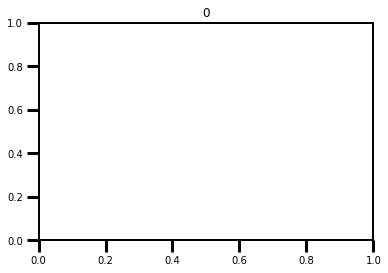

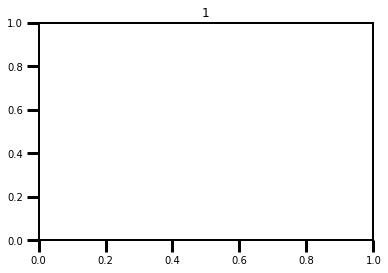

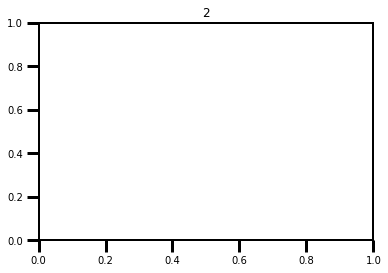

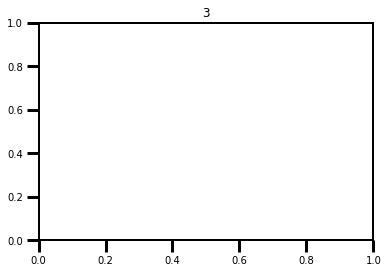

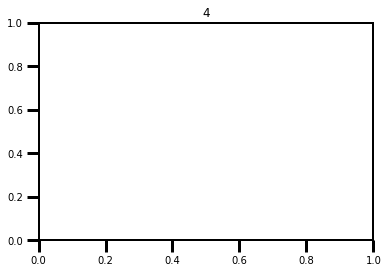

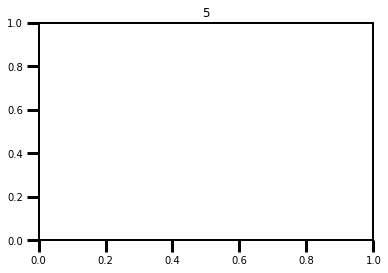

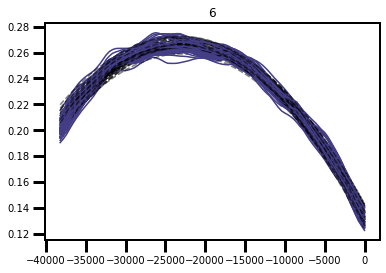

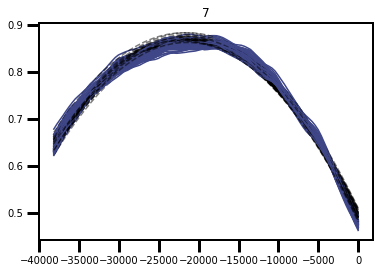

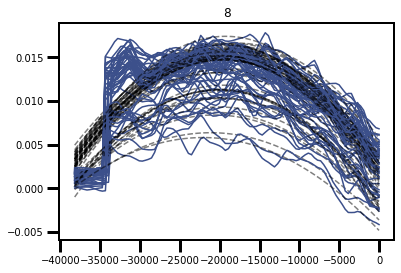

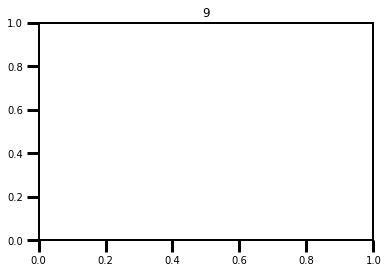

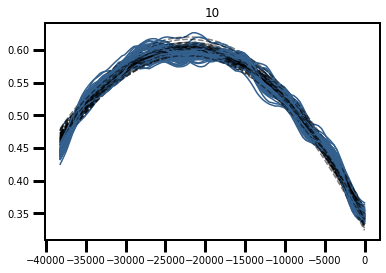

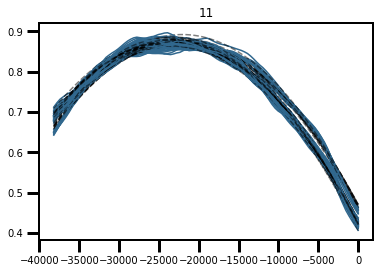

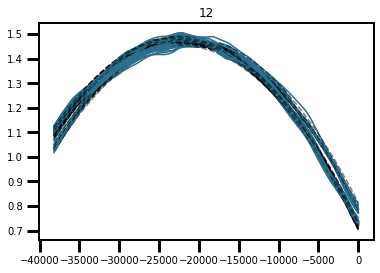

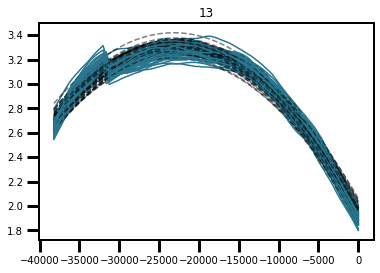

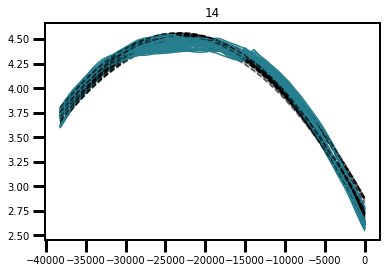

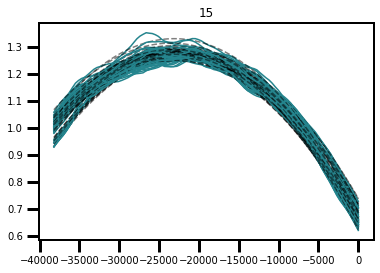

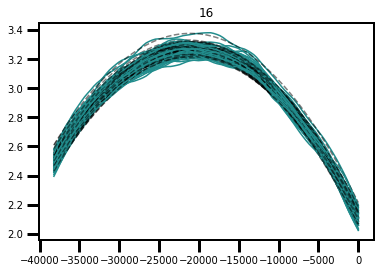

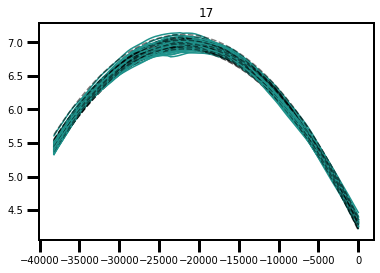

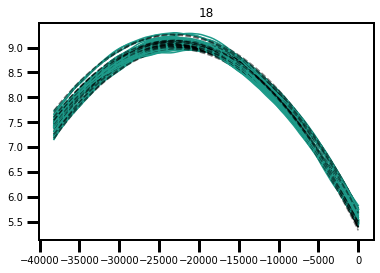

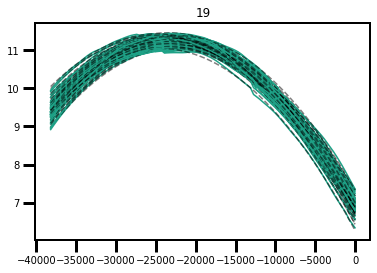

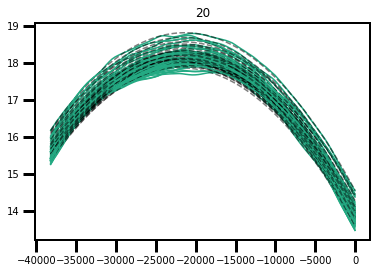

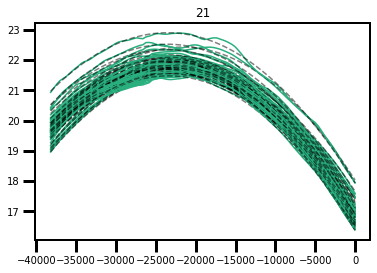

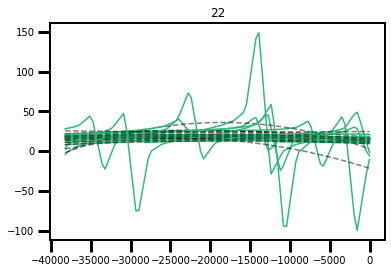

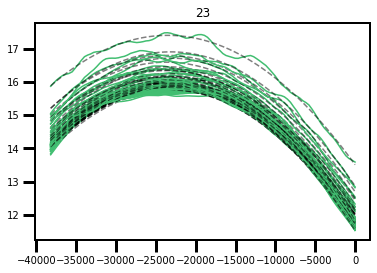

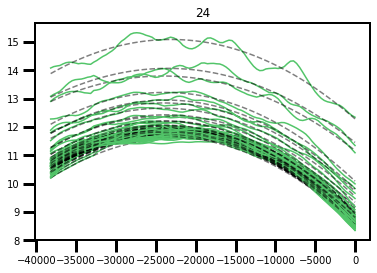

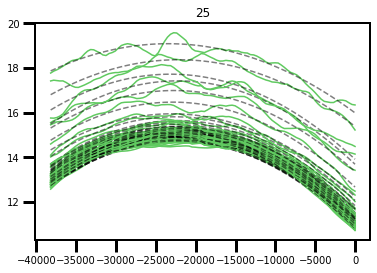

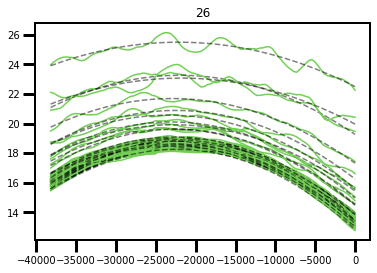

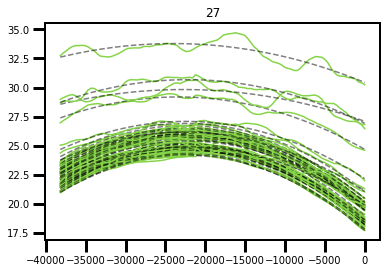

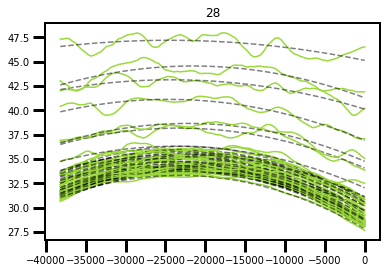

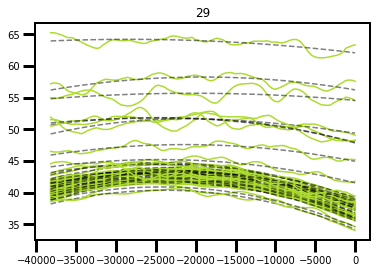

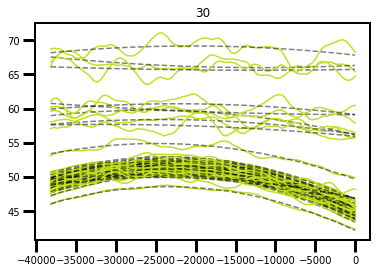

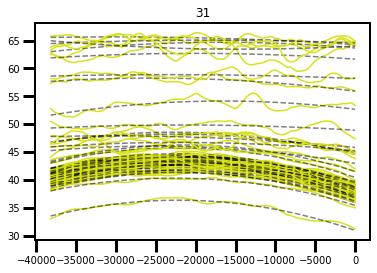

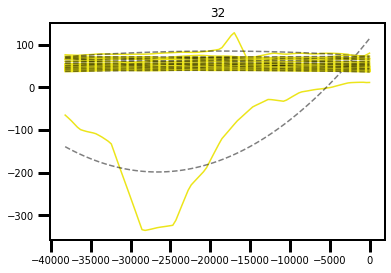

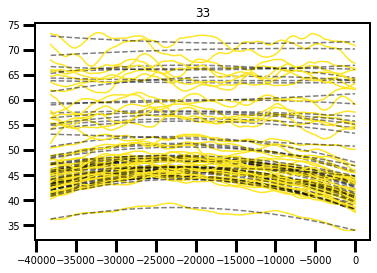

In [1112]:
%matplotlib inline

binary_peaks = np.zeros((likelihoods.shape[0], likelihoods.shape[1]))

for i in np.arange(likelihoods.shape[0]):
    
    for j in range(likelihoods.shape[1]):
        
        if np.nanmedian(likelihoods[i][j]) != 0:
            plt.plot(rvs, likelihoods[i][j],#/np.nanmedian(likelihoods[i][0]), 
                     c=colors[i])
            fit = np.polyfit(rvs, likelihoods[i][j], deg=2)
            maximum = -fit[1]/(2*fit[0])
            binary_peaks[i][j] = maximum
            
            model = np.poly1d(fit)
            plt.plot(rvs, model(rvs), 'k--', alpha=0.5)
        else:
            plt.close()
        
    plt.title(i)
    plt.show()
#plt.xlim(17000,20000)
#plt.ylim(0.99,1.01)

In [1135]:
binary_peaks[only]

array([[-22201.02598568, -22202.03718782, -22155.66196266,
        -22121.28277002, -22076.88004394, -22150.96419113,
        -22191.66392161, -22183.67006559, -22197.68432253,
        -22324.18156586, -22901.94926165, -23098.88449404,
        -22835.11434409, -22954.46158746, -23097.06529932,
        -23179.25366938, -23096.37875   , -23050.29975547,
        -23038.10419255, -23097.38834738, -23150.71053063,
        -23019.48967572, -22912.59536214, -23236.84722434,
        -23033.29841456, -23196.34153264, -23045.95452894,
        -23030.75139488, -23102.3735915 , -23201.95063512,
        -23056.69007559, -23086.05367944, -23130.00762419,
        -23253.04412914, -23094.62074331, -23137.05615017,
        -22953.7883258 , -23257.36205672, -23181.77654637,
        -23144.87421622, -23120.10517461, -23037.03513801,
        -23243.00774419, -23317.94563003, -22957.6441934 ,
        -23234.14887429, -22980.23913854, -23032.27261003,
        -22985.79874247, -23323.9431226 , -23195.0351828

In [1132]:
only = [6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 23, 24]
remove = []
for i in range(len(binary_peaks)):
    if np.nanmedian(binary_peaks[i]) == 0:
        remove.append(i)

(-23.0, -21.0)

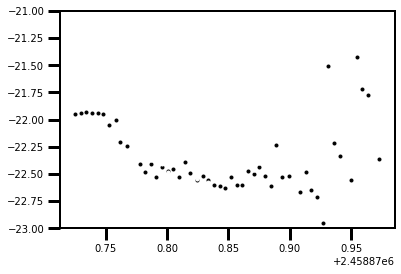

In [1139]:
med_binary = np.nanmean(np.delete(binary_peaks, remove, axis=0), axis=0) * u.m / u.s
med_binary_self = np.nanmean(binary_peaks[only], axis=0) * u.m / u.s

plt.plot(TIMES, med_binary.to(u.km/u.s), 'k.')
plt.plot(TIMES, med_binary_self.to(u.km/u.s), 'w.')
plt.ylim(-23,-21)

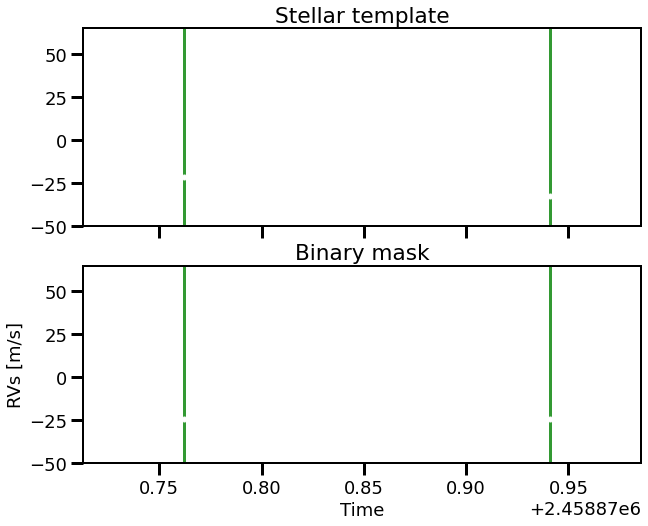

In [833]:
plt.rcParams['font.size'] = 18
plt.rcParams['text.color'] = 'k'
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,8), sharex=True,
                               sharey=True)

ax1.set_title('Stellar template')
ax1.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med2, 'w.', ms=10,
         label='stellar')

med = np.nanmedian(all_binary_peaks[:-82], axis=0)
mean = np.nanmean(all_binary_peaks, axis=0)

ax2.set_title('Binary mask')
ax2.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med, 'w.', ms=10,
         label='binary')

ax1.vlines(TIMES[BOTH[-1]], -100,100, color='g', lw=3, alpha=0.8)
ax1.vlines(TIMES[TRANSIT_C[-1]], -100,100, color='g', lw=3, alpha=0.8)
ax2.vlines(TIMES[BOTH[-1]], -100,100, color='g', lw=3, alpha=0.8)
ax2.vlines(TIMES[TRANSIT_C[-1]], -100,100, color='g', lw=3, alpha=0.8)

plt.ylim(-50,65)
plt.xticks(color='k')
plt.yticks(color='k')
plt.xlabel('Time', color='k')
plt.ylabel('RVs [m/s]', color='k');

# Waterfall Plots

In [42]:
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord
from astropy.time import Time

In [274]:
def create_2d(spectra, inds, region):
    summed_last = spectra[-4]
    in_n_out = np.zeros((len(inds), len(region)))
    for i in range(len(inds)):
        j = inds[i]
        in_n_out[i] = spectra[j][region] / summed_last[region] - 1
    return in_n_out

def plot_2d_velocity(wavelengths, arr, region, line, 
                     vmin, vmax, delta):

    plt.figure(figsize=(12,5))
    for i in range(len(arr)):
        plt.scatter(doppler(wavelengths[i][region], delta) - 
                    doppler(line, delta),
                    np.ones(wavelengths[i][region].shape)-i,
                    c=arr[i] * 100, vmax=vmax,
                    vmin=vmin)
    plt.title('Velocity Space')
    plt.xlabel('V - V$_{Halpha}$ [km s$^{-1}$]')
    plt.ylabel('Time')
    plt.show()

In [275]:
per_c =  8.24958 * u.day
per_d =  12.4032 * u.day
a_c   =  0.0825 * u.AU
a_d   =  0.1083 * u.AU
vel_c = ((np.pi * a_c * 2) / per_c).to(u.km/u.s)
vel_d = ((np.pi * a_d * 2) / per_d).to(u.km/u.s)
vel_c, vel_d

(<Quantity 108.79618028 km / s>, <Quantity 94.99182858 km / s>)

In [276]:
combined = np.sort(np.append(BOTH, TRANSIT_C))

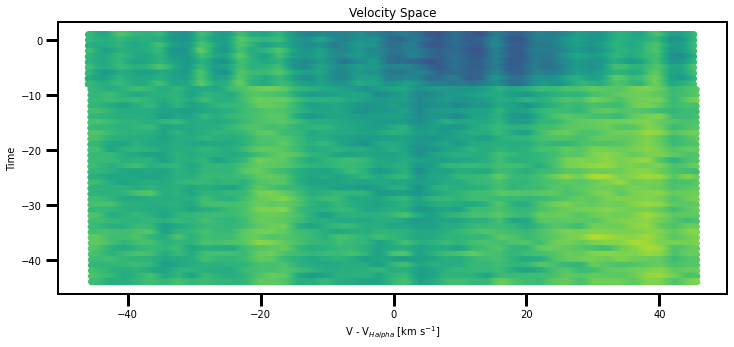

In [277]:
halpha_range = [halpha_position-0.1, halpha_position+0.1]
fit_range = np.where((WAVELENGTHS[10] >= halpha_range[0]) &
                     (WAVELENGTHS[10] <= halpha_range[1]) &
                     (ORDERS[10] == 34))[0]
in_v_out = create_2d(SPECTRA, combined, fit_range)
plot_2d_velocity(WAVELENGTHS, in_v_out, fit_range, 
                 halpha_position, 
                 -15, 4, halpha_true)

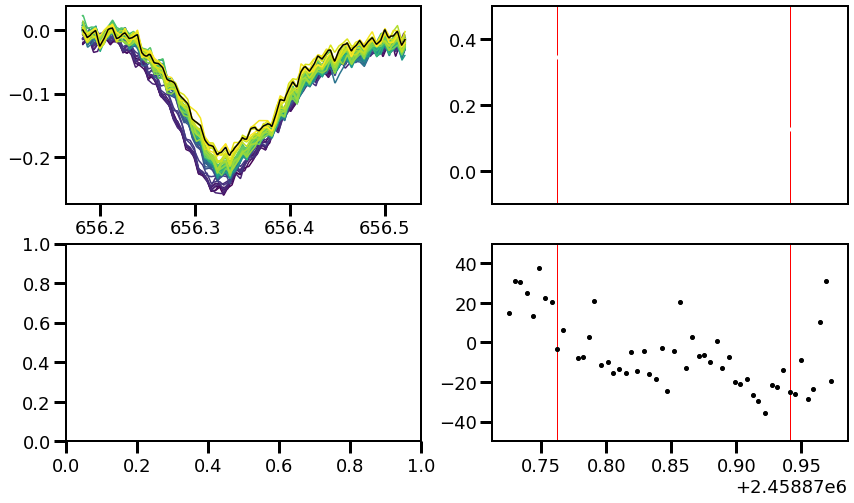

In [501]:
offset = 0.95
out_of_transits = np.nanmedian(SPECTRA[len(WAVELENGTHS)-4: len(WAVELENGTHS)], axis=0) - offset
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(14,8))
for i in range(len(WAVELENGTHS)):
    inds = np.where((WAVELENGTHS[i] >= halpha_range[0]-0.05) &
                     (WAVELENGTHS[i] <= halpha_range[1]+0.09) &
                     (ORDERS[i] == 34))[0]
    ax1.plot(WAVELENGTHS[i][inds], 
             SPECTRA[i][inds]-offset, c=colors[i])
    sub = SPECTRA[i][inds]-offset
    ax2.plot(TIMES[i], np.nansum(sub)/np.sum(out_of_transits[inds])-1, 'w.')
ax1.plot(WAVELENGTHS[i][inds], out_of_transits[inds], 'k')

ax2.set_xticks([])

med = np.nanmedian(all_peaks[:-10], axis=0)

ax2.vlines(TIMES[BOTH[-1]], -100,100, color='r', lw=1)
ax2.vlines(TIMES[TRANSIT_C[-1]], -100,100, color='r', lw=1)
ax2.set_ylim(-0.1,0.5)
ax4.vlines(TIMES[BOTH[-1]], -100,100, color='r', lw=1)
ax4.vlines(TIMES[TRANSIT_C[-1]], -100,100, color='r', lw=1)
ax4.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med, 'k.', ms=8)
#plt.plot(TIMES, np.nanmedian(np.diff(np.log(subwave))) * 3e8 * mean, 'k.')
ax4.set_ylim(-50,50)

plt.show()

In [541]:
np.save('rvs_21082020.npy', np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med1)

In [542]:
np.nanmedian(np.diff(np.log(subwave))) * 3e8 * med1

array([-18.24534157,   5.76129248,   9.18613323,   9.58874422,
         1.02625153,  26.17965265,  -7.38772309,  15.74380224,
       -21.24817228, -11.53812095, -10.15449139, -12.77142735,
        -8.27364759,  24.40329683, -11.63324494, -14.18197179,
       -11.28645007,  -3.47566845, -13.11367417,   0.44301478,
       -12.01117307,   5.40562689, -15.5392613 , -21.65896104,
        17.91013214, -12.53535557,  -1.23975036,  16.5559635 ,
       -20.46545762,   0.63278447,  -8.41944466,  -8.09044695,
        -9.49185945,  -2.07748229, -14.20525884,  -6.43220691,
       -21.81381708, -18.73313912, -12.47579374, -27.75028337,
       -36.50354205, -45.73715936, -25.52903877, -15.71268187,
        11.92521316, -32.26628911, -31.4483855 ,  23.30939874,
       -31.95395942,  -2.99453668,  21.01117092,  20.6990646 ,
       -13.61587668])